In [1]:
# =============================================================================
# ionizeDL: A Deep Learning Framework for Ionospheric Forecasting
#
# Author: Ioannis Ntagkas
# Institutions: NCSR "Demokritos", University of Peloponnese
# Date: 2025-07-06
#
# Description:
# This script implements a full pipeline for forecasting the ionospheric F2 layer
# critical frequency (foF2). It includes modules for fetching and caching
# real-world data, feature engineering, and training/evaluating two deep
# learning architectures: a baseline LSTM with Attention and a state-of-the-art
# Temporal Fusion Transformer (TFT).
# =============================================================================

# --- Core and System Libraries ---
import os
import io
import time
import warnings
from datetime import datetime
from pathlib import Path
import pickle

# --- Data Handling and Numerical Libraries ---
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler

# --- DL Libraries (PyTorch) ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# --- Third-Party and Visualization Libraries ---
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


# --- Initial Setup and Configuration ---

# Suppress minor warnings for a cleaner output log.
warnings.filterwarnings('ignore')

# Set a consistent, professional style for all generated plots.
sns.set_theme(style="whitegrid", palette="deep")

def set_seed(seed_value=42):
    """
    Sets the seed for all relevant random number generators to ensure
    reproducibility of results.
    
    Args:
        seed_value (int): The integer value to use as the seed.
    """
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)

# Set the global seed for the project.
SEED = 42
set_seed(SEED)

# Automatically detect and select the best available compute device.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("--- ionizeDL Project Initialization ---")
print(f"PyTorch Version: {torch.__version__}")
print(f"Selected Compute Device: {device}")
print(f"Reproducibility Seed: {SEED}")

--- ionizeDL Project Initialization ---
PyTorch Version: 2.7.0+cu118
Selected Compute Device: cuda
Reproducibility Seed: 42


In [2]:
# =============================================================================
# SECTION 1: PROJECT CONFIGURATION
# =============================================================================

# --- High-Level Experiment Control ---
# The script now supports a multi-stage experiment.
# MODE 1: 'LSTM_TFT_COMPARISON' - Settiong for the main (LSTM vs. TFT) comparison.
# MODE 2: 'SSM_EXPERIMENT' - Setting for the SSM.

MODE = 'LSTM_TFT_COMPARISON' # Toggle between 'LSTM_TFT_COMPARISON' (default) & 'SSM_EXPERIMENT' (experimental)

APPLY_DENOISING = True # Set to 'True' to enable the signal processing step. Modify as desired.

# --- Directory and Path Configuration ---
PROJECT_ROOT = Path.home() / "ionizeDL"
DATA_DIR = PROJECT_ROOT / "data"
MODELS_DIR = PROJECT_ROOT / "models"
RESULTS_DIR = PROJECT_ROOT / "results"

DATA_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)

# --- Data Source Configuration ---
OMNI_CONFIG = {
    "start_date": datetime(2000, 1, 1),
    "end_date": datetime(2022, 12, 31),
    "cache_path": DATA_DIR / "omni_data_2000_2022.pkl" # Remember to adjust dates here as well.
}

FOF2_CONFIG = {
    "station_code": "MHJ45",
    "char_name": "foF2",
    "cs_threshold": 60,
    "cache_path": DATA_DIR / "fof2_MHJ45_2000_2022.pkl" # Remember to adjust dates here as well.
}

# --- Experiment-Specific Parameters ---
# Custom sequence lengths for the LSTM vs. TFT comparison.
LSTM_TFT_SEQUENCE_LENGTHS = [12, 24, 36, 48, 60] # Prefer list form (even for a single value). Modify values as desired!

# Custom sequence lengths for the SSM experiment.
SSM_SEQUENCE_LENGTHS = [12, 24] # Prefer list form (even for a single value). Modify values as desired!

# --- General Model and Training Hyperparameters ---
# Modify as desired

MODEL_PARAMS = {
    "sequence_length": 24, # Default initial value, replaced by the custom lengths
    "prediction_horizon": 3,
    "input_features": -1,
    "hidden_dim": 128, # Values tried: 64, 128
    "num_layers": 4, # Values tried: 2, 4
    "dropout": 0.2 # Values tried: in the range 0.2-0.3
}

TRAINING_PARAMS = {
    "num_epochs": 30,
    "batch_size": 32,
    "learning_rate": 4e-4, # Values tried: in the range 5e-4--3e-4.
    "patience": 8 # Values tried: 10, 8
}

print("\n--- Experiment Configuration ---")
print(f"Execution Mode: {MODE}")
print(f"Apply Denoising: {APPLY_DENOISING}")
print("-" * 32)


--- Experiment Configuration ---
Execution Mode: LSTM_TFT_COMPARISON
Apply Denoising: True
--------------------------------


In [3]:
# =============================================================================
# SECTION 2: DATA FETCHING & PROCESSING
# =============================================================================

def fetch_omni_data(start_date, end_date, cache_path):
    """
    Fetches and caches OMNI hourly data from NASA SPDF.
    
    This function downloads the OMNI2 1-hour resolution dataset, which contains
    key solar wind parameters and geomagnetic indices vital for ionospheric modeling.
    It handles missing values and data type conversions using a robust column-
    indexing method to handle inconsistencies in the source files.
    
    Reference: King, J. H., & Papitashvili, N. E. (2005). Solar wind data from
               the OMNIWeb database. Journal of Geophysical Research.

    Args:
        start_date (datetime): The start date for the data fetch.
        end_date (datetime): The end date for the data fetch.
        cache_path (Path): The file path to save/load the cached data.

    Returns:
        pd.DataFrame: A DataFrame containing the processed OMNI data.
    """
    if cache_path.exists():
        print(f"Loading cached OMNI data from: {cache_path}")
        return pd.read_pickle(cache_path)

    print(f"Fetching real OMNI data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
    base_url = "https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/"
    all_data_frames = []
    
    for year in tqdm(range(start_date.year, end_date.year + 1), desc="Fetching OMNI years"):
        filename = f"omni2_{year}.dat"
        file_url = base_url + filename
        try:
            response = requests.get(file_url, timeout=30)
            response.raise_for_status() 
        except requests.exceptions.RequestException as e:
            tqdm.write(f"Error fetching {filename}: {e}") 
            continue
            
        data_lines = response.text.splitlines()
        if not data_lines: continue
            
        try:
            df_year = pd.read_csv(io.StringIO("\n".join(data_lines)), delim_whitespace=True, header=None)
            selected_cols_map = {0: 'YEAR', 1: 'DOY', 2: 'HR', 39: 'F107', 14: 'Bz_GSM', 21: 'bulk_speed', 22: 'proton_density', 31: 'AE', 30: 'Dst'}
            max_idx = df_year.shape[1] - 1
            valid_cols_map = {k: v for k, v in selected_cols_map.items() if k <= max_idx}
            if not all(key in valid_cols_map for key in [0, 1, 2]): continue
            df_year_selected = df_year[list(valid_cols_map.keys())].copy()
            df_year_selected.rename(columns=valid_cols_map, inplace=True)
        except Exception: continue

        fill_values = {'F107': [999.9], 'Bz_GSM': [999.9], 'bulk_speed': [9999.0], 'proton_density': [999.99], 'AE': [9999], 'Dst': [99999]}
        for col, fills in fill_values.items():
            if col in df_year_selected.columns:
                for f_val in fills: df_year_selected[col] = df_year_selected[col].replace(f_val, np.nan)
                    
        df_year_selected['timestamp'] = pd.to_datetime(df_year_selected['YEAR'].astype(int).astype(str) + '-' + df_year_selected['DOY'].astype(int).astype(str), format='%Y-%j') + pd.to_timedelta(df_year_selected['HR'].astype(int), unit='h')
        all_data_frames.append(df_year_selected[['timestamp'] + [c for c in fill_values if c in df_year_selected]])

    if not all_data_frames: return pd.DataFrame()
    
    omni_df = pd.concat(all_data_frames, ignore_index=True)
    omni_df = omni_df.sort_values('timestamp').drop_duplicates('timestamp').reset_index(drop=True)
    
    for col in ['Bz_GSM', 'proton_density', 'bulk_speed', 'F107', 'Dst', 'AE']:
        if col not in omni_df.columns: omni_df[col] = 0
        omni_df[col] = pd.to_numeric(omni_df[col], errors='coerce').ffill().bfill().fillna(0)
        
    omni_df.to_pickle(cache_path)
    print(f"Successfully fetched and cached {len(omni_df)} OMNI records.")
    return omni_df

def fetch_fof2_data(start_date, end_date, station_code, char_name, cs_threshold, cache_path):
    """
    Fetches and caches ionosonde data from the Lowell GIRO Data Center (LGDC).
    
    This function queries the LGDC DIDB database, filters data based on a confidence
    score (CS) to remove unreliable measurements, and resamples the data to a
    consistent hourly cadence.
    
    Reference: Reinisch, B. W., & Galkin, I. A. (2011). Global Ionospheric
               Radio Observatory (GIRO). Radio Science.

    Args:
        start_date (datetime): The overall start date for the data fetch.
        end_date (datetime): The overall end date for the data fetch.
        station_code (str): The URSI code for the ionosonde station.
        char_name (str): The ionospheric characteristic to fetch (e.g., "foF2").
        cs_threshold (int): The minimum confidence score to accept a measurement.
        cache_path (Path): The file path to save/load the cached data.

    Returns:
        pd.DataFrame: A DataFrame containing the processed foF2 data.
    """
    if cache_path.exists():
        print(f"Loading cached {char_name} data from: {cache_path}")
        return pd.read_pickle(cache_path)

    print(f"Fetching {char_name} data for station {station_code}...")
    all_fof2_dfs = []
    base_url = "http://lgdc.uml.edu/common/DIDBGetValues"
    
    for year in tqdm(range(start_date.year, end_date.year + 1), desc=f"Fetching {char_name} years"):
        chunk_start, chunk_end = datetime(year, 1, 1), datetime(year, 12, 31, 23, 59, 59)
        params = {
            'ursiCode': station_code, 'charName': char_name,
            'fromDate': max(start_date, chunk_start).strftime('%Y/%m/%d %H:%M:%S'),
            'toDate': min(end_date, chunk_end).strftime('%Y/%m/%d %H:%M:%S')
        }
        try:
            response = requests.get(base_url, params=params, timeout=90)
            response.raise_for_status()
        except requests.exceptions.RequestException: continue
            
        data_lines = [line for line in response.text.splitlines() if line.strip() and not line.strip().startswith('#')]
        if not data_lines: continue
            
        try:
            df_year = pd.read_csv(io.StringIO("\n".join(data_lines)), delim_whitespace=True, header=None, names=['Time', 'CS', 'Value', 'Qual'], na_values=['//'])
            df_year['Time'] = pd.to_datetime(df_year['Time'], errors='coerce')
            df_year.dropna(subset=['Time'], inplace=True)
            df_year['Value'] = pd.to_numeric(df_year['Value'], errors='coerce').replace(-1, np.nan)
            df_year.loc[pd.to_numeric(df_year['CS'], errors='coerce') < cs_threshold, 'Value'] = np.nan
            all_fof2_dfs.append(df_year[['Time', 'Value']])
        except Exception: continue
            
    if not all_fof2_dfs: return pd.DataFrame()
    
    fof2_df = pd.concat(all_fof2_dfs, ignore_index=True).set_index('Time')
    fof2_hourly = fof2_df[~fof2_df.index.duplicated(keep='first')]['Value'].resample('H').mean().reset_index()
    fof2_hourly.rename(columns={'Time': 'timestamp', 'Value': char_name}, inplace=True)
    
    fof2_hourly.to_pickle(cache_path)
    print(f"Successfully fetched and cached {len(fof2_hourly)} hourly records for {station_code}.")
    return fof2_hourly

In [4]:
# =============================================================================
# SECTION 3: SIGNAL PROCESSING (DENOISING)
# =============================================================================

def remove_spikes_mad(df, column_name, window_size=24, threshold=3.5):
    """
    Identifies and removes outliers from a time series using the Median
    Absolute Deviation (MAD) method within a rolling window.
    
    The MAD is a robust measure of statistical dispersion. It is more resilient
    to outliers than the standard deviation because it is based on the median,
    which is not affected by extreme values. This function calculates MAD over
    a rolling window to adapt to local signal characteristics.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column to denoise.
        window_size (int): The size of the rolling window (in hours).
        threshold (float): The number of MADs from the median to consider a point an outlier.

    Returns:
        pd.Series: The denoised time-series.
    """
    series = df[column_name].copy()
    rolling_median = series.rolling(window=window_size, center=True, min_periods=1).median()
    
    # Calculate the Median Absolute Deviation (MAD)
    def mad_func(x):
        return (x - x.median()).abs().median()
        
    rolling_mad = series.rolling(window=window_size, center=True, min_periods=1).apply(mad_func)
    
    # The factor 1.4826 is a scaling constant to make MAD a consistent
    # estimator for the standard deviation of a normal distribution.
    outlier_mask = (series - rolling_median).abs() > (threshold * rolling_mad * 1.4826)
    
    # Replace outliers with the rolling median
    cleaned_series = series.copy()
    cleaned_series[outlier_mask] = rolling_median[outlier_mask]
    
    num_outliers = outlier_mask.sum()
    if num_outliers > 0:
        print(f"   - Removed {num_outliers} outliers using MAD method.")
        
    return cleaned_series

def apply_denoising(df, target_col):
    """
    Applies a two-step denoising process to the target variable.
    
    Step 1: A rolling median filter is applied to smooth high-frequency noise.
    Step 2: The MAD method is used to remove any remaining large spikes.

    Args:
        df (pd.DataFrame): The DataFrame containing the target data.
        target_col (str): The name of the target column (e.g., 'foF2').

    Returns:
        pd.DataFrame: The DataFrame with the denoised target column.
    """
    print("Applying denoising...")
    
    # Ensure the column exists
    if target_col not in df.columns:
        print(f"Warning: Target column '{target_col}' not found for denoising.")
        return df
        
    # Step 1: Apply a gentle rolling median filter to smooth minor noise.
    # A small window of 3 hours is effective for this.
    df[target_col] = df[target_col].rolling(window=3, center=True, min_periods=1).median()
    print("   - Applied 3-hour rolling median filter for smoothing.")
    
    # Step 2: Apply MAD-based outlier removal to eliminate large spikes.
    df[target_col] = remove_spikes_mad(df, target_col)
    
    return df

In [5]:
# =============================================================================
# SECTION 4: DATA PREPARATION PIPELINE
# =============================================================================

class IonosphericDataset(Dataset):
    """
    A custom PyTorch Dataset for creating sequences of ionospheric data.
    
    This class takes a pre-scaled DataFrame and generates sequences of a specified
    length for model input, along with the corresponding target value at a future
    prediction horizon.
    """
    def __init__(self, df, feature_cols, target_col, sequence_length, prediction_horizon):
        self.features = df[feature_cols].values
        self.targets = df[target_col].values
        self.sequence_length = sequence_length
        self.prediction_horizon = prediction_horizon

    def __len__(self):
        """Returns the total number of possible sequences that can be created."""
        return len(self.features) - self.sequence_length - self.prediction_horizon + 1

    def __getitem__(self, idx):
        """Retrieves a single input sequence and its corresponding target value."""
        sequence_end_idx = idx + self.sequence_length
        target_idx = sequence_end_idx + self.prediction_horizon - 1
        input_sequence = self.features[idx:sequence_end_idx]
        target_value = self.targets[target_idx]
        return (
            torch.tensor(input_sequence, dtype=torch.float32),
            torch.tensor([target_value], dtype=torch.float32)
        )

def create_dataloaders(df, feature_cols, target_col, model_params, training_params):
    """
    Creates and returns train, validation, and test DataLoaders.
    
    This function encapsulates the critical data preparation steps of CHRONOLOGICAL
    data splitting - and likewise for feature scaling - to prevent DATA LEAKAGE, essential for (future-)predictive models.
    
    More concretely, PERSISTENCE would be exploitable *backwards* - which is illegitimate - in addition to forwards - which is entirely desirable! 
    For instance, models could extrapolate to our predictive target - say, t=+1 - from data further in the future - for instance, t=+2, +5, +6, ... - if available from training.
    They shouldn't be, though; as they won't be -by definition- in any real-life (future-)predictive deployment.
    """
    print("Splitting data chronologically and creating DataLoaders...")
    train_end_idx = int(len(df) * 0.7)
    val_end_idx = int(len(df) * 0.85)

    df_train, df_val, df_test = df.iloc[:train_end_idx].copy(), df.iloc[train_end_idx:val_end_idx].copy(), df.iloc[val_end_idx:].copy()

    # Scaler for input features
    feature_scaler = RobustScaler()
    df_train.loc[:, feature_cols] = feature_scaler.fit_transform(df_train[feature_cols])
    df_val.loc[:, feature_cols] = feature_scaler.transform(df_val[feature_cols])
    df_test.loc[:, feature_cols] = feature_scaler.transform(df_test[feature_cols])

    # Separate scaler for target variable
    target_scaler = RobustScaler()
    df_train.loc[:, [target_col]] = target_scaler.fit_transform(df_train[[target_col]])
    df_val.loc[:, [target_col]] = target_scaler.transform(df_val[[target_col]])
    df_test.loc[:, [target_col]] = target_scaler.transform(df_test[[target_col]])

    dataset_params = {
        'sequence_length': model_params['sequence_length'],
        'prediction_horizon': model_params['prediction_horizon']
    }
    train_ds = IonosphericDataset(df_train, feature_cols, target_col, **dataset_params)
    val_ds = IonosphericDataset(df_val, feature_cols, target_col, **dataset_params)
    test_ds = IonosphericDataset(df_test, feature_cols, target_col, **dataset_params)
    
    is_gpu = (device.type == 'cuda')
    train_loader = DataLoader(train_ds, batch_size=training_params['batch_size'], shuffle=True, num_workers=0, pin_memory=is_gpu)
    val_loader = DataLoader(val_ds, batch_size=training_params['batch_size'], shuffle=False, num_workers=0, pin_memory=is_gpu)
    test_loader = DataLoader(test_ds, batch_size=training_params['batch_size'], shuffle=False, num_workers=0, pin_memory=is_gpu)
    
    print(f"DataLoaders created. Training sequences: {len(train_ds)}")
    
    # 3. Return the loaders AND both scalers
    return train_loader, val_loader, test_loader, feature_scaler, target_scaler

def get_processed_data():
    """Orchestrates the data pipeline: fetches, denoises, and engineers features."""
    print("\n--- Preparing Model-Ready Dataset ---")
    omni_data = fetch_omni_data(**OMNI_CONFIG)
    fof2_data = fetch_fof2_data(start_date=OMNI_CONFIG["start_date"], end_date=OMNI_CONFIG["end_date"], **FOF2_CONFIG) # Using same start_date & end_date with OMNI
    
    def ensure_utc(df, col='timestamp'):
        """FIX: Correctly localizes or converts the timestamp column to UTC."""
        df[col] = pd.to_datetime(df[col])
        if df[col].dt.tz is None:
            df[col] = df[col].dt.tz_localize('UTC')
        else:
            df[col] = df[col].dt.tz_convert('UTC')
        return df
        
    df = pd.merge(ensure_utc(omni_data), ensure_utc(fof2_data), on='timestamp', how='inner')
    df.sort_values('timestamp', inplace=True)
    df.drop_duplicates(subset=['timestamp'], keep='first', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    target_col = FOF2_CONFIG['char_name']
    df.dropna(subset=[target_col], inplace=True)
    
    if APPLY_DENOISING:
        df = apply_denoising(df, target_col)
        
    print("Engineering features...")
    df['hour_sin'] = np.sin(2 * np.pi * df['timestamp'].dt.hour / 24.0)
    df['hour_cos'] = np.cos(2 * np.pi * df['timestamp'].dt.hour / 24.0)
    df['doy_sin'] = np.sin(2 * np.pi * df['timestamp'].dt.dayofyear / 365.25)
    df['doy_cos'] = np.cos(2 * np.pi * df['timestamp'].dt.dayofyear / 365.25)
    
    lags = [1, 2, 3, 6, 12, 24]
    for lag in lags:
        df[f'{target_col}_lag_{lag}H'] = df[target_col].shift(lag)
    
    df.dropna(inplace=True)
    
    print(f"Final model-ready dataset created with {len(df)} records.")
    return df.reset_index(drop=True)

In [6]:
# =============================================================================
# SECTION 5: PYTORCH DATASET & DATALOADERS
# =============================================================================

class IonosphericDataset(Dataset):
    """
    A custom PyTorch Dataset for creating sequences of ionospheric data.
    """
    def __init__(self, df, feature_cols, target_col, sequence_length, prediction_horizon):
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.sequence_length = sequence_length
        self.prediction_horizon = prediction_horizon
        self.features = df[self.feature_cols].values
        self.targets = df[self.target_col].values

    def __len__(self):
        return len(self.features) - self.sequence_length - self.prediction_horizon + 1

    def __getitem__(self, idx):
        sequence_end_idx = idx + self.sequence_length
        target_idx = sequence_end_idx + self.prediction_horizon - 1
        input_sequence = self.features[idx:sequence_end_idx]
        target_value = self.targets[target_idx]
        return (
            torch.tensor(input_sequence, dtype=torch.float32),
            torch.tensor([target_value], dtype=torch.float32)
        )

def create_dataloaders(df, feature_cols, target_col, model_params, training_params):
    """
    Creates and returns train, validation, and test DataLoaders, along with separate,
    fitted scalers for the features and the target variable.
    """
    print("Splitting data chronologically and creating DataLoaders...")
    train_end_idx = int(len(df) * 0.7)
    val_end_idx = int(len(df) * 0.85)

    df_train = df.iloc[:train_end_idx].copy()
    df_val = df.iloc[train_end_idx:val_end_idx].copy()
    df_test = df.iloc[val_end_idx:].copy()

    # Scaler for input features
    feature_scaler = RobustScaler()
    df_train.loc[:, feature_cols] = feature_scaler.fit_transform(df_train[feature_cols])
    df_val.loc[:, feature_cols] = feature_scaler.transform(df_val[feature_cols])
    df_test.loc[:, feature_cols] = feature_scaler.transform(df_test[feature_cols])

    # Separate scaler for target variable
    target_scaler = RobustScaler()
    df_train.loc[:, [target_col]] = target_scaler.fit_transform(df_train[[target_col]])
    df_val.loc[:, [target_col]] = target_scaler.transform(df_val[[target_col]])
    df_test.loc[:, [target_col]] = target_scaler.transform(df_test[[target_col]])

    train_dataset = IonosphericDataset(df_train, feature_cols, target_col, model_params['sequence_length'], model_params['prediction_horizon'])
    val_dataset = IonosphericDataset(df_val, feature_cols, target_col, model_params['sequence_length'], model_params['prediction_horizon'])
    test_dataset = IonosphericDataset(df_test, feature_cols, target_col, model_params['sequence_length'], model_params['prediction_horizon'])

    is_gpu = (device.type == 'cuda')
    train_loader = DataLoader(train_dataset, batch_size=training_params['batch_size'], shuffle=True, num_workers=0, pin_memory=is_gpu)
    val_loader = DataLoader(val_dataset, batch_size=training_params['batch_size'], shuffle=False, num_workers=0, pin_memory=is_gpu)
    test_loader = DataLoader(test_dataset, batch_size=training_params['batch_size'], shuffle=False, num_workers=0, pin_memory=is_gpu)
    
    print(f"DataLoaders created. Training sequences: {len(train_dataset)}")
    
    # 3. Return the loaders AND both scalers
    return train_loader, val_loader, test_loader, feature_scaler, target_scaler

In [7]:
# =============================================================================
# SECTION 6: MODEL ARCHITECTURES (LSTM, TFT)
# =============================================================================

# --- LSTM ---

class IonosphericPredictorLSTM(nn.Module):
    """
    A baseline model using a *bidirectional* Long Short-Term Memory (LSTM) 
    enhanced with an attention mechanism.
    
    Reference (LSTM): Hochreiter, S., & Schmidhuber, J. (1997).
    Reference (Attention): Bahdanau, D., et al. (2014).
    """
    def __init__(self, input_features, hidden_dim, num_layers, dropout):
        super().__init__()
        self.feature_embed = nn.Sequential(nn.Linear(input_features, hidden_dim), nn.ReLU(), nn.Dropout(dropout))
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0, bidirectional=True)
        self.attention = nn.Sequential(nn.Linear(hidden_dim * 2, hidden_dim), nn.Tanh(), nn.Linear(hidden_dim, 1), nn.Softmax(dim=1))
        self.output_layer = nn.Sequential(nn.Linear(hidden_dim * 2, hidden_dim), nn.ReLU(), nn.Dropout(dropout), nn.Linear(hidden_dim, 1))

    def forward(self, x):
        embedded = self.feature_embed(x)
        lstm_out, _ = self.lstm(embedded)
        attention_weights = self.attention(lstm_out)
        context_vector = torch.sum(lstm_out * attention_weights, dim=1)
        output = self.output_layer(context_vector)
        return output, attention_weights

# --- TFT Component Classes ---

class GatedLinearUnit(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=None):
        super().__init__()
        self.dropout = nn.Dropout(dropout) if dropout else None
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(input_size, hidden_size)
    def forward(self, x):
        if self.dropout: x = self.dropout(x)
        return F.glu(torch.cat([self.fc1(x), self.fc2(x)], dim=-1), dim=-1)

class GatedResidualNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.1):
        super().__init__()
        self.proj_in = nn.Linear(input_size, hidden_size)
        self.elu = nn.ELU()
        self.proj_out = nn.Linear(hidden_size, hidden_size)
        self.gate = GatedLinearUnit(hidden_size, hidden_size, dropout)
        self.norm = nn.LayerNorm(hidden_size)
        self.res_proj = nn.Linear(input_size, hidden_size) if input_size != hidden_size else nn.Identity()
        self.final_proj = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        res = self.res_proj(x)
        x = self.elu(self.proj_in(x))
        x = self.proj_out(x)
        x = self.gate(x)
        return self.final_proj(self.norm(x + res))

class VariableSelectionNetwork(nn.Module):
    def __init__(self, num_inputs, hidden_size, dropout=0.1):
        super().__init__()
        self.grn = GatedResidualNetwork(num_inputs * hidden_size, hidden_size, num_inputs, dropout)
    def forward(self, x):
        weights = F.softmax(self.grn(x.flatten(1)), dim=-1).unsqueeze(-1)
        return x * weights, weights

class InterpretableMultiHeadAttention(nn.Module):
    def __init__(self, n_head, d_model, dropout=0.1):
        super().__init__()
        self.n_head, self.d_k = n_head, d_model // n_head
        self.qkv_proj = nn.Linear(d_model, d_model * 3, bias=False)
        self.out_proj = nn.Linear(d_model, d_model, bias=False)
        self.norm = nn.LayerNorm(d_model)
    def forward(self, x):
        res = x
        q, k, v = self.qkv_proj(x).chunk(3, dim=-1)
        q = q.view(*x.shape[:-1], self.n_head, self.d_k).transpose(-3, -2)
        k = k.view(*x.shape[:-1], self.n_head, self.d_k).transpose(-3, -2)
        v = v.view(*x.shape[:-1], self.n_head, self.d_k).transpose(-3, -2)
        attn_scores = F.softmax(torch.matmul(q, k.transpose(-1, -2)) / np.sqrt(self.d_k), dim=-1)
        attn_output = torch.matmul(attn_scores, v).transpose(-3, -2).contiguous().view(*x.shape)
        return self.norm(self.out_proj(attn_output) + res), attn_scores

class FlashMultiHeadAttention(nn.Module): # Added for completeness. Does not return attention weights for visualization, though.
    """
    A high-performance multi-head attention mechanism that uses PyTorch's
    built-in scaled_dot_product_attention function. Leverages
    FlashAttention-like optimizations for significant speed and memory improvements,
    but it does not return the attention weights for visualization.
    """
    def __init__(self, n_head, d_model, dropout=0.1):
        super().__init__()
        self.n_head, self.d_k = n_head, d_model // n_head
        self.qkv_proj = nn.Linear(d_model, d_model * 3, bias=False)
        self.out_proj = nn.Linear(d_model, d_model, bias=False)
        self.norm = nn.LayerNorm(d_model)
        self.dropout_p = dropout
    def forward(self, x):
        res = x
        q, k, v = self.qkv_proj(x).chunk(3, dim=-1)
        q = q.view(*x.shape[:-1], self.n_head, self.d_k).transpose(-3, -2)
        k = k.view(*x.shape[:-1], self.n_head, self.d_k).transpose(-3, -2)
        v = v.view(*x.shape[:-1], self.n_head, self.d_k).transpose(-3, -2)
        
        # Use the optimized backend
        attn_output = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout_p if self.training else 0.0)
        
        attn_output = attn_output.transpose(-3, -2).contiguous().view(*x.shape)
        
        # Return dummy scores for API compatibility
        dummy_scores = torch.zeros(q.size(0), self.n_head, q.size(2), k.size(2), device=q.device)
        return self.norm(self.out_proj(attn_output) + res), dummy_scores


# --- TFT ---

class TemporalFusionTransformer(nn.Module):
    """
    A modern Temporal Fusion Transformer (TFT) model.
    Reference: Lim, B., Arık, S. Ö., et al. (2021).
    """
    def __init__(self, input_size, hidden_size=64, num_layers=2, n_head=4, dropout=0.1, use_flash_attention=False):
        super().__init__()
        self.projections = nn.ModuleList([nn.Linear(1, hidden_size) for _ in range(input_size)])
        self.vsn = VariableSelectionNetwork(input_size, hidden_size, dropout)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.lstm_gate, self.lstm_norm = GatedLinearUnit(hidden_size, hidden_size, dropout), nn.LayerNorm(hidden_size)
        self.enrichment = GatedResidualNetwork(hidden_size, hidden_size, hidden_size, dropout)
        
        # --- Toggle between attention implementations --- Default: use_flash_attention=False. Keep in mind that flash attention does not return weights for visuals.
        if use_flash_attention:
            print("--- Using FlashMultiHeadAttention (Performance-Optimized) ---")
            self.attention = FlashMultiHeadAttention(n_head, hidden_size, dropout)
        else:
            print("--- Using InterpretableMultiHeadAttention (Default) ---")
            self.attention = InterpretableMultiHeadAttention(n_head, hidden_size, dropout)
        
        self.attn_gate, self.attn_norm = GatedLinearUnit(hidden_size, hidden_size, dropout), nn.LayerNorm(hidden_size)
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        proj_x = torch.stack([p(x[..., i:i+1]) for i, p in enumerate(self.projections)], dim=2)
        
        vsn_outputs, vsn_weights_list = [], []
        for t in range(x.size(1)):
            out, weights = self.vsn(proj_x[:, t, :, :])
            vsn_outputs.append(out)
            # Collect weights from *every* timestep
            vsn_weights_list.append(weights)
            
        # Stack the collected weights
        # Creates a tensor of shape (batch_size, sequence_length, num_features)
        self.variable_selection_weights = torch.stack(vsn_weights_list, dim=1)
        
        x = torch.stack(vsn_outputs, dim=1).sum(dim=2)
        lstm_out, _ = self.lstm(x)
        x = self.lstm_norm(x + self.lstm_gate(lstm_out))
        x = self.enrichment(x)
        attn_out, self.temporal_attention_weights = self.attention(x)
        x = self.attn_norm(x + self.attn_gate(attn_out))
        output = self.output_layer(x[:, -1, :])
        
        return output, self.temporal_attention_weights

print("Model architectures (IonosphericPredictorLSTM, TemporalFusionTransformer) defined successfully.")

Model architectures (IonosphericPredictorLSTM, TemporalFusionTransformer) defined successfully.


In [22]:
# =============================================================================
# SECTION 7: TRAINING, EVALUATION, VISUALIZATION
# =============================================================================

# --- Training ---

def train_model(model, train_loader, val_loader, model_params, training_params, model_savename):
    """
    A generic training loop for a given PyTorch model 
    """
    start_time = time.time()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=training_params['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)
    best_val_loss, patience_counter = float('inf'), 0

    # Lists to store loss history
    train_loss_history, val_loss_history = [], []
    
    print(f"\n--- Starting Training for {model.__class__.__name__} ---")
    for epoch in range(training_params['num_epochs']):
        model.train()
        running_train_loss = 0.0
        
        # Increased mininterval to reduce message rate
        # Updates progress bar at most once every 2 sec
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{training_params['num_epochs']} [Train]", leave=False, mininterval=2.0)
        
        for inputs, targets in train_pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs, _ = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_train_loss += loss.item()
            train_pbar.set_postfix(loss=f"{loss.item():.4f}")
        avg_train_loss = running_train_loss / len(train_loader)
        
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs, _ = model(inputs.to(device))
                loss = criterion(outputs, targets.to(device))
                running_val_loss += loss.item()
        avg_val_loss = running_val_loss / len(val_loader)
        
        # Store the loss for this epoch
        train_loss_history.append(avg_train_loss)
        val_loss_history.append(avg_val_loss)
        
        print(f"Epoch {epoch+1:02d}/{training_params['num_epochs']} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            # Save parameters alongside model weights
            checkpoint = {
                'model_params': {k: v for k, v in model_params.items() if k in ['input_features', 'hidden_dim', 'num_layers', 'dropout']},
                'state_dict': model.state_dict()
            }
            torch.save(checkpoint, model_savename)
            print(f"  -> Val loss improved. Saving model to {model_savename.name}")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"  -> Val loss did not improve. Patience: {patience_counter}/{training_params['patience']}")
        if patience_counter >= training_params['patience']:
            print("\nEarly stopping triggered. Training finished.")
            break
            
    training_time = time.time() - start_time
    print(f"--- Training Finished in {training_time:.2f} seconds ---")
    
    return training_time, train_loss_history, val_loss_history

# --- Evaluation ---

def evaluate_model(model, test_loader, target_scaler, device):
    """
    Evaluates a trained model on the test set, with corrected data handling for all models.
    """
    model.eval()
    predictions, actuals = [], []
    temporal_outputs, variable_selections = [], []
    is_tft = isinstance(model, TemporalFusionTransformer)
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc=f"Evaluating {model.__class__.__name__}"):
            outputs, attention_or_gate = model(inputs.to(device))
            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(targets.cpu().numpy().flatten())

            # Correctly collect sample-wise data by extending the list
            if attention_or_gate is not None:
                # .extend() unpacks the batch dimension, collecting sample-wise data
                temporal_outputs.extend(attention_or_gate.cpu().numpy())
            
            if is_tft and hasattr(model, 'variable_selection_weights'):
                variable_selections.extend(model.variable_selection_weights.cpu().numpy())

    # Inverse transform to get physical values
    predictions_rescaled = target_scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    actuals_rescaled = target_scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()
    results = {'predictions': predictions_rescaled, 'actuals': actuals_rescaled}
    
    # Calculate metrics in physical units
    results['rmse'] = np.sqrt(np.mean((results['predictions'] - results['actuals']) ** 2))
    results['correlation'] = np.corrcoef(results['predictions'], results['actuals'])[0, 1]
    storm_mask = results['actuals'] > 8.0
    results['storm_rmse'] = np.sqrt(np.mean((results['predictions'][storm_mask] - results['actuals'][storm_mask])**2)) if storm_mask.any() else np.nan

    # Process and average the collected interpretability data
    if temporal_outputs:
        # Averages over all samples in the test set (the first axis)
        results['attention'] = np.mean(np.array(temporal_outputs), axis=0)
    if variable_selections:
        results['variable_selection'] = np.mean(np.array(variable_selections), axis=0)
        
    return results


# --- Visualization ---

def plot_results(results, feature_cols, model_name, seq_len):
    """
    Generates & saves a plot of the model's performance, with metrics and corrected attention plotting.
    """
    is_tft = 'variable_selection' in results
    fig, axes = plt.subplots(2, 2, figsize=(18, 14), gridspec_kw={'height_ratios': [2, 2]})
    fig.suptitle(f'{model_name} Performance (Sequence Length: {seq_len} hours)', fontsize=18)

    # Plot 1: Predictions vs. Actuals (with metrics restored)
    ax = axes[0, 0]
    ax.scatter(results['actuals'], results['predictions'], alpha=0.3, s=15)
    ax.plot([results['actuals'].min(), results['actuals'].max()], [results['actuals'].min(), results['actuals'].max()], 'r--', lw=2, label='Ideal')
    metrics_text = (f"RMSE: {results['rmse']:.3f}\n"
                    f"Correlation: {results['correlation']:.3f}\n"
                    f"Storm RMSE: {results.get('storm_rmse', float('nan')):.3f}")
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax.set_xlabel('Actual foF2 (MHz)'); ax.set_ylabel('Predicted foF2 (MHz)')
    ax.set_title('Prediction vs. Actual', fontsize=14); ax.legend(); ax.grid(True)

    # Plot 2: Error Distribution
    ax = axes[0, 1]
    errors = results['predictions'] - results['actuals']
    sns.histplot(errors, bins=50, kde=True, ax=ax, color='purple')
    ax.axvline(errors.mean(), color='red', linestyle='--', label=f"Mean Error: {errors.mean():.3f}")
    ax.set_xlabel('Prediction Error (MHz)'); ax.set_ylabel('Frequency')
    ax.set_title('Error Distribution', fontsize=14); ax.legend()

    # Plot 3: Feature Importance (TFT only)
    ax = axes[1, 0]
    ax.set_title('Feature Importance', fontsize=14)
    if is_tft and 'variable_selection' in results and results['variable_selection'] is not None:
        pd.Series(results['variable_selection'].flatten(), index=feature_cols).sort_values(ascending=True).plot(kind='barh', ax=ax)
        ax.set_xlabel('Gated Importance Weight')
    else:
        ax.text(0.5, 0.5, "Not available for this model", ha='center', va='center', style='italic', color='gray')
        ax.set_xticks([]); ax.set_yticks([])
    ax.grid(True, axis='x', linestyle=':')

    # Plot 4: Temporal Attention Pattern
    ax = axes[1, 1]
    ax.set_title('Temporal Attention Pattern', fontsize=14)
    attention_data = results.get('attention')
    
    if attention_data is not None and attention_data.size > 0:
        # Handle different attention data shapes
        if is_tft and attention_data.ndim == 4:  # TFT attention is 4D: (samples, heads, L, L)
            # Average over samples to get (heads, L, L)
            attention_data = np.mean(attention_data, axis=0)
            
        if is_tft and attention_data.ndim == 3:  # TFT attention is 3D: (heads, L, L)
            final_step_attention = attention_data[:, -1, :]  # Get attention to final step
            time_lags = range(-final_step_attention.shape[1] + 1, 1)
            for i in range(final_step_attention.shape[0]):
                ax.plot(time_lags, final_step_attention[i, :], linestyle='-', alpha=0.2, color='gray')
            ax.plot(time_lags, np.mean(final_step_attention, axis=0), marker='o', linestyle='-', markersize=5, label='Mean Attention')
            ax.legend()
            ax.set_ylabel('Attention Weight')
        else:  # LSTM/SSM attention is averaged to 1D
            plot_data = np.mean(np.squeeze(attention_data), axis=0)
            time_lags = range(-len(plot_data) + 1, 1)
            ax.plot(time_lags, plot_data, marker='o', linestyle='-', markersize=5)
            ax.set_ylabel('Average Attention Weight')        
        ax.set_xlabel('Time Lag from Prediction (Hours)')
        ax.grid(True, linestyle=':')
    else:
        ax.text(0.5, 0.5, "No attention data available", ha='center', va='center', style='italic', color='gray')
        ax.set_xticks([]); ax.set_yticks([])

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    save_path = RESULTS_DIR / f"{model_name.lower()}_len{seq_len}_performance.png"
    plt.savefig(save_path, dpi=300)
    print(f"\nResults plot saved to: {save_path}")
    plt.show()



def plot_loss_curves(results_log_df, all_results_data, mode_name):
    """
    Generates and saves a single figure with training & 
    validation loss curves for all completed model runs.
    """
    # Filter for runs that have a non-empty loss history available
    valid_runs = {k: v for k, v in all_results_data.items() if 'train_loss_history' in v and v['train_loss_history']}
    if not valid_runs:
        print("No loss history found in any processed runs. Skipping loss plot generation.")
        return

    num_runs = len(valid_runs)
    # Arrange plots in a grid
    ncols = min(3, num_runs)
    nrows = (num_runs + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows), squeeze=False)
    axes = axes.flatten()

    for i, (run_id, data) in enumerate(valid_runs.items()):
        ax = axes[i]
        epochs = range(1, len(data['train_loss_history']) + 1)
        ax.plot(epochs, data['train_loss_history'], 'b-o', markersize=4, label='Training Loss')
        ax.plot(epochs, data['val_loss_history'], 'r-o', markersize=4, label='Validation Loss')
        ax.set_title(run_id.replace("_", " - ") + " hours")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("MSE Loss")
        ax.legend()
        ax.grid(True, linestyle=':')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Training & Validation Loss Curves", fontsize=24, y=1.03)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    
    save_path = RESULTS_DIR / f"{mode_name}_loss_curves.png"
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    print(f"\nLoss curves plot saved to: {save_path}")
    plt.show()


def plot_comparative_attention(results_log_df, all_results_data):
    """Generates a comparative plot of temporal attention patterns."""
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('Comparative Temporal Attention Patterns', fontsize=20, y=1.02)
    
    model_types_in_data = sorted([mtype for mtype in results_log_df['model_type'].unique() if mtype in ['LSTM', 'TFT']])

    for i, model_type in enumerate(model_types_in_data):
        ax = axes[i]
        model_df = results_log_df[results_log_df['model_type'] == model_type].sort_values('sequence_length')
        ax.set_title(f'{model_type}', fontsize=16)

        if model_type == 'LSTM':
            all_attention_values = [] # To find max value for scaling y-axis
            
            for _, row in model_df.iterrows():
                run_id = f"{model_type}_{row['sequence_length']}"
                if run_id in all_results_data and all_results_data[run_id].get('attention') is not None:
                    attention_data = np.mean(np.squeeze(all_results_data[run_id]['attention']), axis=0)
                    all_attention_values.extend(attention_data)
                    time_lags = range(-len(attention_data) + 1, 1)
                    ax.plot(time_lags, attention_data, marker='.', label=f'{row["sequence_length"]}h')
            
            # Set y-axis limit to utilize plot area effectively
            if all_attention_values:
                ax.set_ylim(0, max(all_attention_values) * 1.1)
                
            ax.set_xlabel('Time Lag from Prediction (Hours)')
            ax.set_ylabel('Average Attention Weight')
            ax.legend(title='Input Window')
            ax.grid(True, linestyle=':') # Ensures an even grid


        elif model_type == 'TFT':
            tft_df = model_df.copy()
            if tft_df.empty: continue
            max_len = tft_df['sequence_length'].max()
            
            heatmap_data, yticklabels = [], []
            for _, row in tft_df.iterrows():
                seq_len, run_id = row['sequence_length'], f"{model_type}_{row['sequence_length']}"
                if run_id in all_results_data and all_results_data[run_id].get('attention') is not None:
                    attention_data = all_results_data[run_id]['attention']
                    
                    # Handle 4D attention data from TFT
                    if attention_data.ndim == 4:  # (samples, heads, L, L)
                        # Average over samples and heads to get (L, L)
                        attention_data = np.mean(attention_data, axis=(0, 1))
                    elif attention_data.ndim == 3:  # (heads, L, L)
                        # Average over heads to get (L, L)
                        attention_data = np.mean(attention_data, axis=0)
                    
                    # Get attention to final step (last row of attention matrix)
                    final_step_attention = attention_data[-1, :]  # Shape: (L,)
                    
                    # Pad to match max_len
                    padding = max_len - len(final_step_attention)
                    padded_data = np.pad(final_step_attention, (padding, 0), 'constant', constant_values=np.nan)
                    heatmap_data.append(padded_data)
                    yticklabels.append(f'{seq_len}h')

            if not heatmap_data: continue
            
            # Convert to 2D array for heatmap
            heatmap_array = np.array(heatmap_data)  # Shape: (num_models, max_len)
            
            sns.heatmap(heatmap_array, ax=ax, cmap='viridis', cbar_kws={'label': 'Attention Weight'}, yticklabels=yticklabels)
            
            tick_positions = np.arange(max_len)
            tick_labels = [f"{-(max_len-1)+i}" for i in tick_positions]
            display_ticks_every = max(1, max_len // 8)
            ax.set_xticks(tick_positions[::display_ticks_every] + 0.5)
            ax.set_xticklabels(tick_labels[::display_ticks_every], rotation=0)
            ax.set_xlabel('Time Lag from Prediction (Hours)')
            ax.set_ylabel('Input Window Size')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    save_path = RESULTS_DIR / "comparative_attention_patterns.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nComparative attention plot saved to: {save_path}")
    plt.show()

def plot_ssm_diagnostics(results, model_name, seq_len):
    """
    Generates a diagnostic plot for the SSM (Mamba) model, visualizing
    performance and the model's internal input selectivity.
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f'{model_name} Performance & Diagnostics (Sequence Length: {seq_len} hours)', fontsize=16)

    # Plot 1: Prediction vs. Actual
    ax = axes[0]
    ax.scatter(results['actuals'], results['predictions'], alpha=0.5, edgecolors='w', s=30, label='Predicted-Actual pairs')
    lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(lims, lims, 'r--', label='Perfect Prediction', lw=2)
    ax.set_xlabel('Actual foF2 (MHz)')
    ax.set_ylabel('Predicted foF2 (MHz)')
    ax.set_title(f"Prediction vs. Actual\nCorr: {results['correlation']:.3f} | RMSE: {results['rmse']:.3f} MHz")
    ax.legend()
    ax.set_aspect('equal', 'box')
    ax.grid(True, linestyle=':')

    # Plot 2: Input Gate Magnitude (SSM's version of "attention")
    ax = axes[1]
    gate_data = results.get('attention') # Gate values are retrieved using 'attention' key from evaluate_model
    if gate_data is not None and gate_data.size > 0:
        avg_gate_data = np.mean(np.squeeze(gate_data), axis=0) # Average the gate magnitudes across the batch dimension
        time_lags = range(-seq_len + 1, 1)
        ax.plot(time_lags, avg_gate_data, marker='o', linestyle='-', markersize=5, color='darkcyan')
        ax.set_xlabel('Time Lag from Prediction (Hours)')
        ax.set_ylabel('Average Input Gate Magnitude')
        ax.set_title('SSM Input Selectivity Gate')
        ax.grid(True, linestyle=':')
    else:
        ax.text(0.5, 0.5, "No gate data available", ha='center', va='center', style='italic', color='gray')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    save_path = RESULTS_DIR / f"{model_name.lower()}_len{seq_len}_diagnostics.png"
    plt.savefig(save_path, dpi=300)
    print(f"\nSSM diagnostic plot saved to: {save_path}")
    plt.show()

--- Found existing results log at: /home/ioda/ionizeDL/results/results_log.csv ---

--- Starting Comparison Experiment: LSTM vs. TFT ---

--- Preparing Model-Ready Dataset ---
Loading cached OMNI data from: /home/ioda/ionizeDL/data/omni_data_2000_2022.pkl
Loading cached foF2 data from: /home/ioda/ionizeDL/data/fof2_MHJ45_2000_2022.pkl
Applying denoising...
   - Applied 3-hour rolling median filter for smoothing.
   - Removed 4269 outliers using MAD method.
Engineering features...
Final model-ready dataset created with 179198 records.

--- PROCESSING LSTM_12 (Sequence Length: 12 hours) ---
--- Loading detailed results for LSTM_12 for visualization. ---

Results plot saved to: /home/ioda/ionizeDL/results/lstm_len12_performance.png


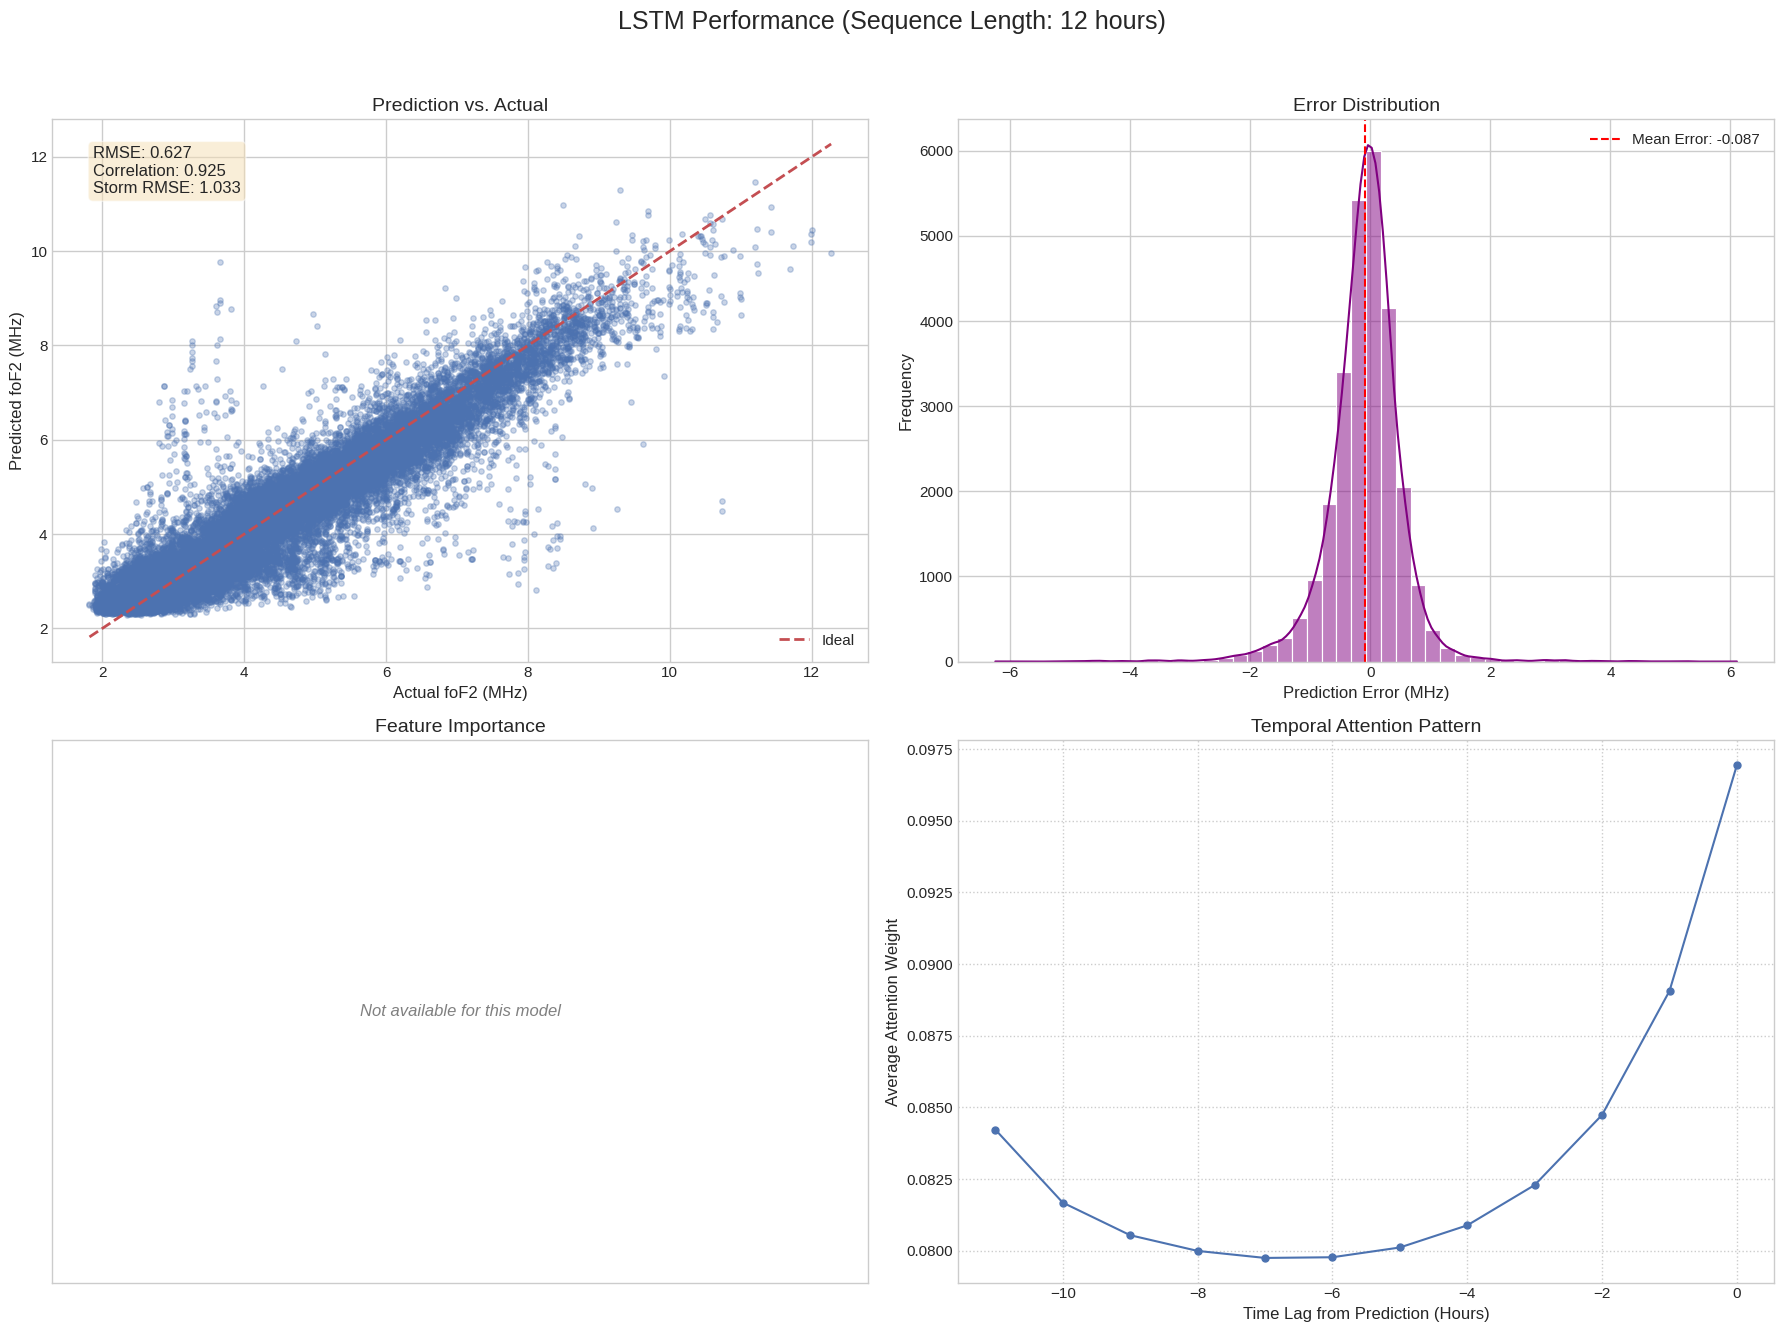


--- PROCESSING LSTM_24 (Sequence Length: 24 hours) ---
--- Loading detailed results for LSTM_24 for visualization. ---

Results plot saved to: /home/ioda/ionizeDL/results/lstm_len24_performance.png


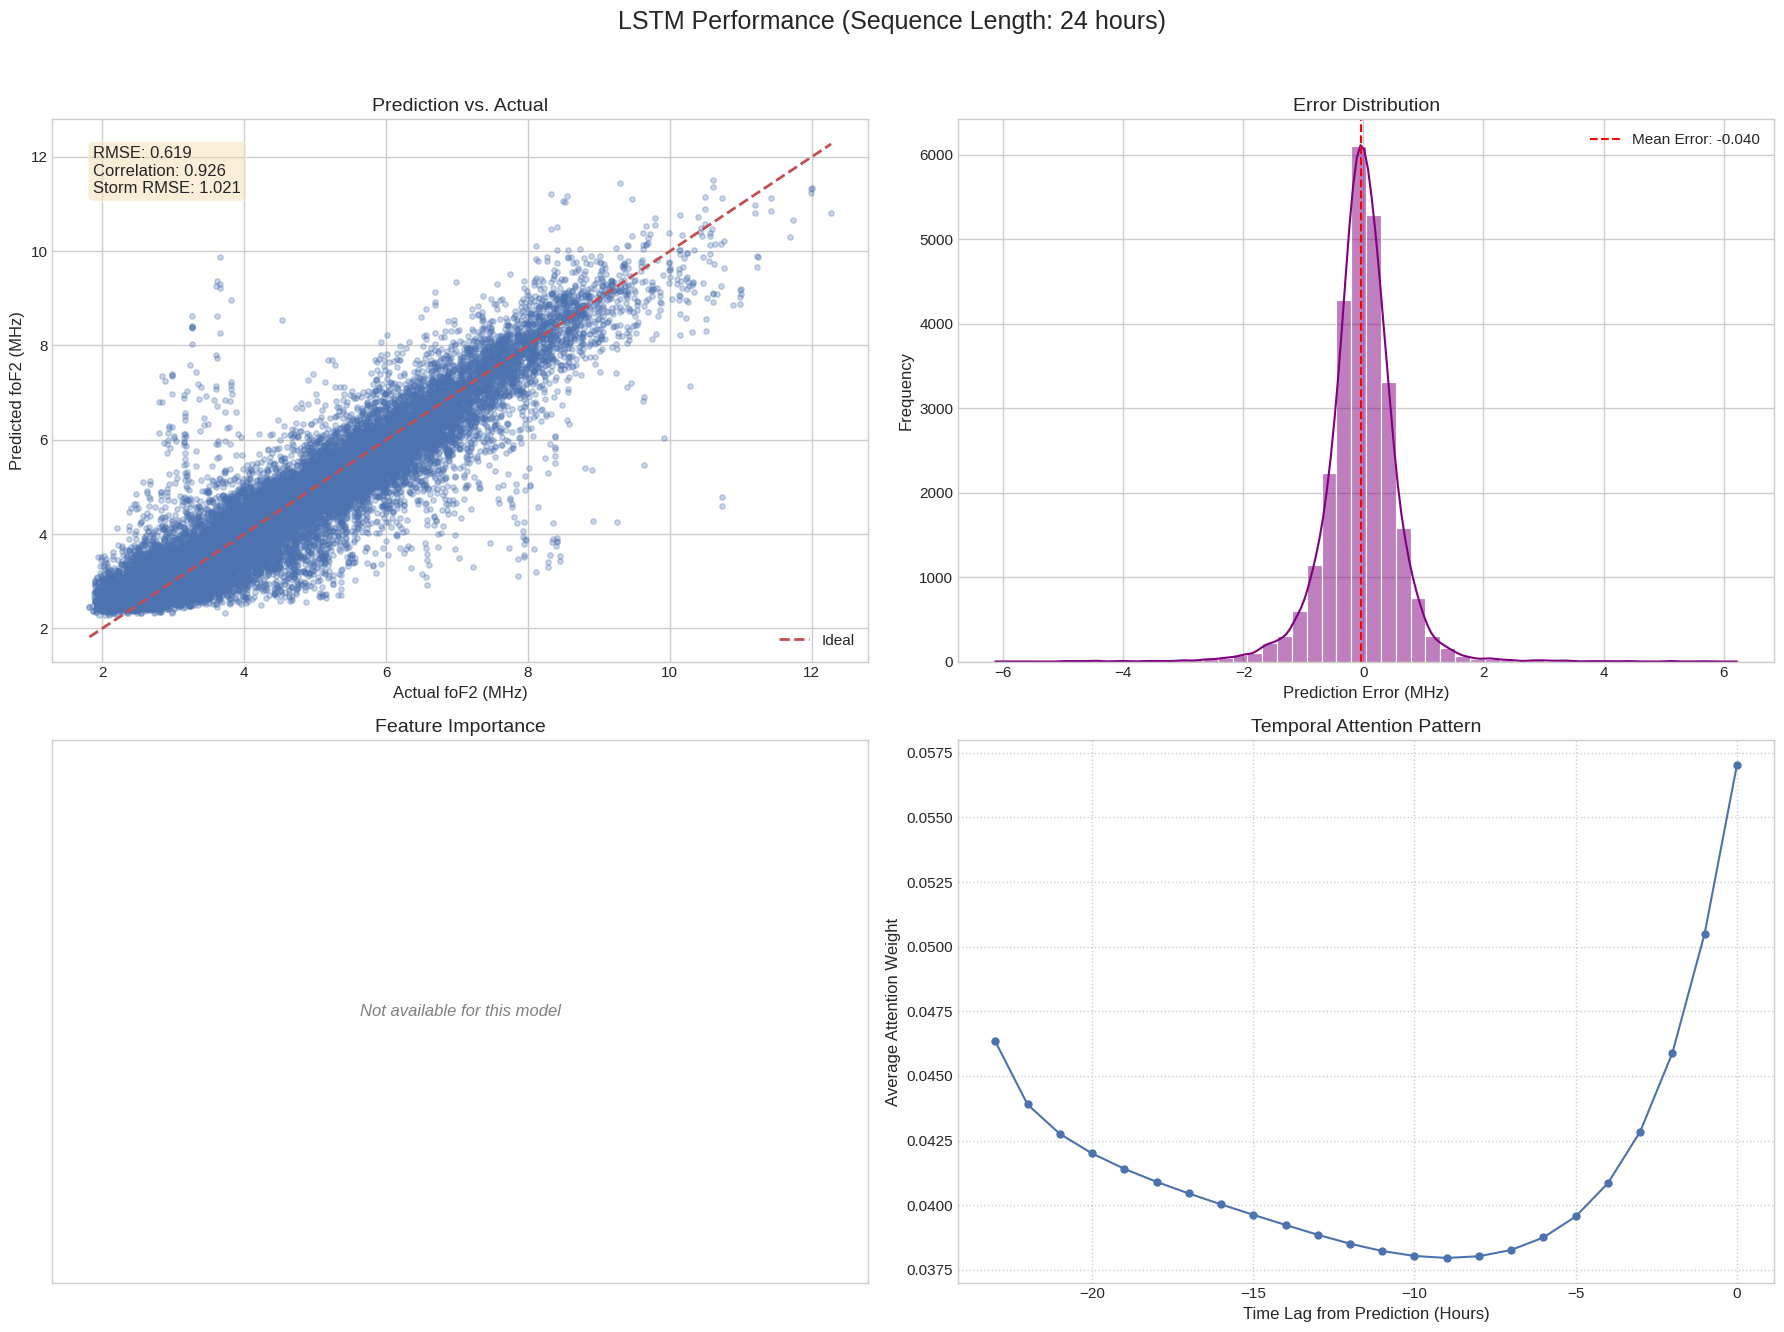


--- PROCESSING LSTM_36 (Sequence Length: 36 hours) ---
--- Loading detailed results for LSTM_36 for visualization. ---

Results plot saved to: /home/ioda/ionizeDL/results/lstm_len36_performance.png


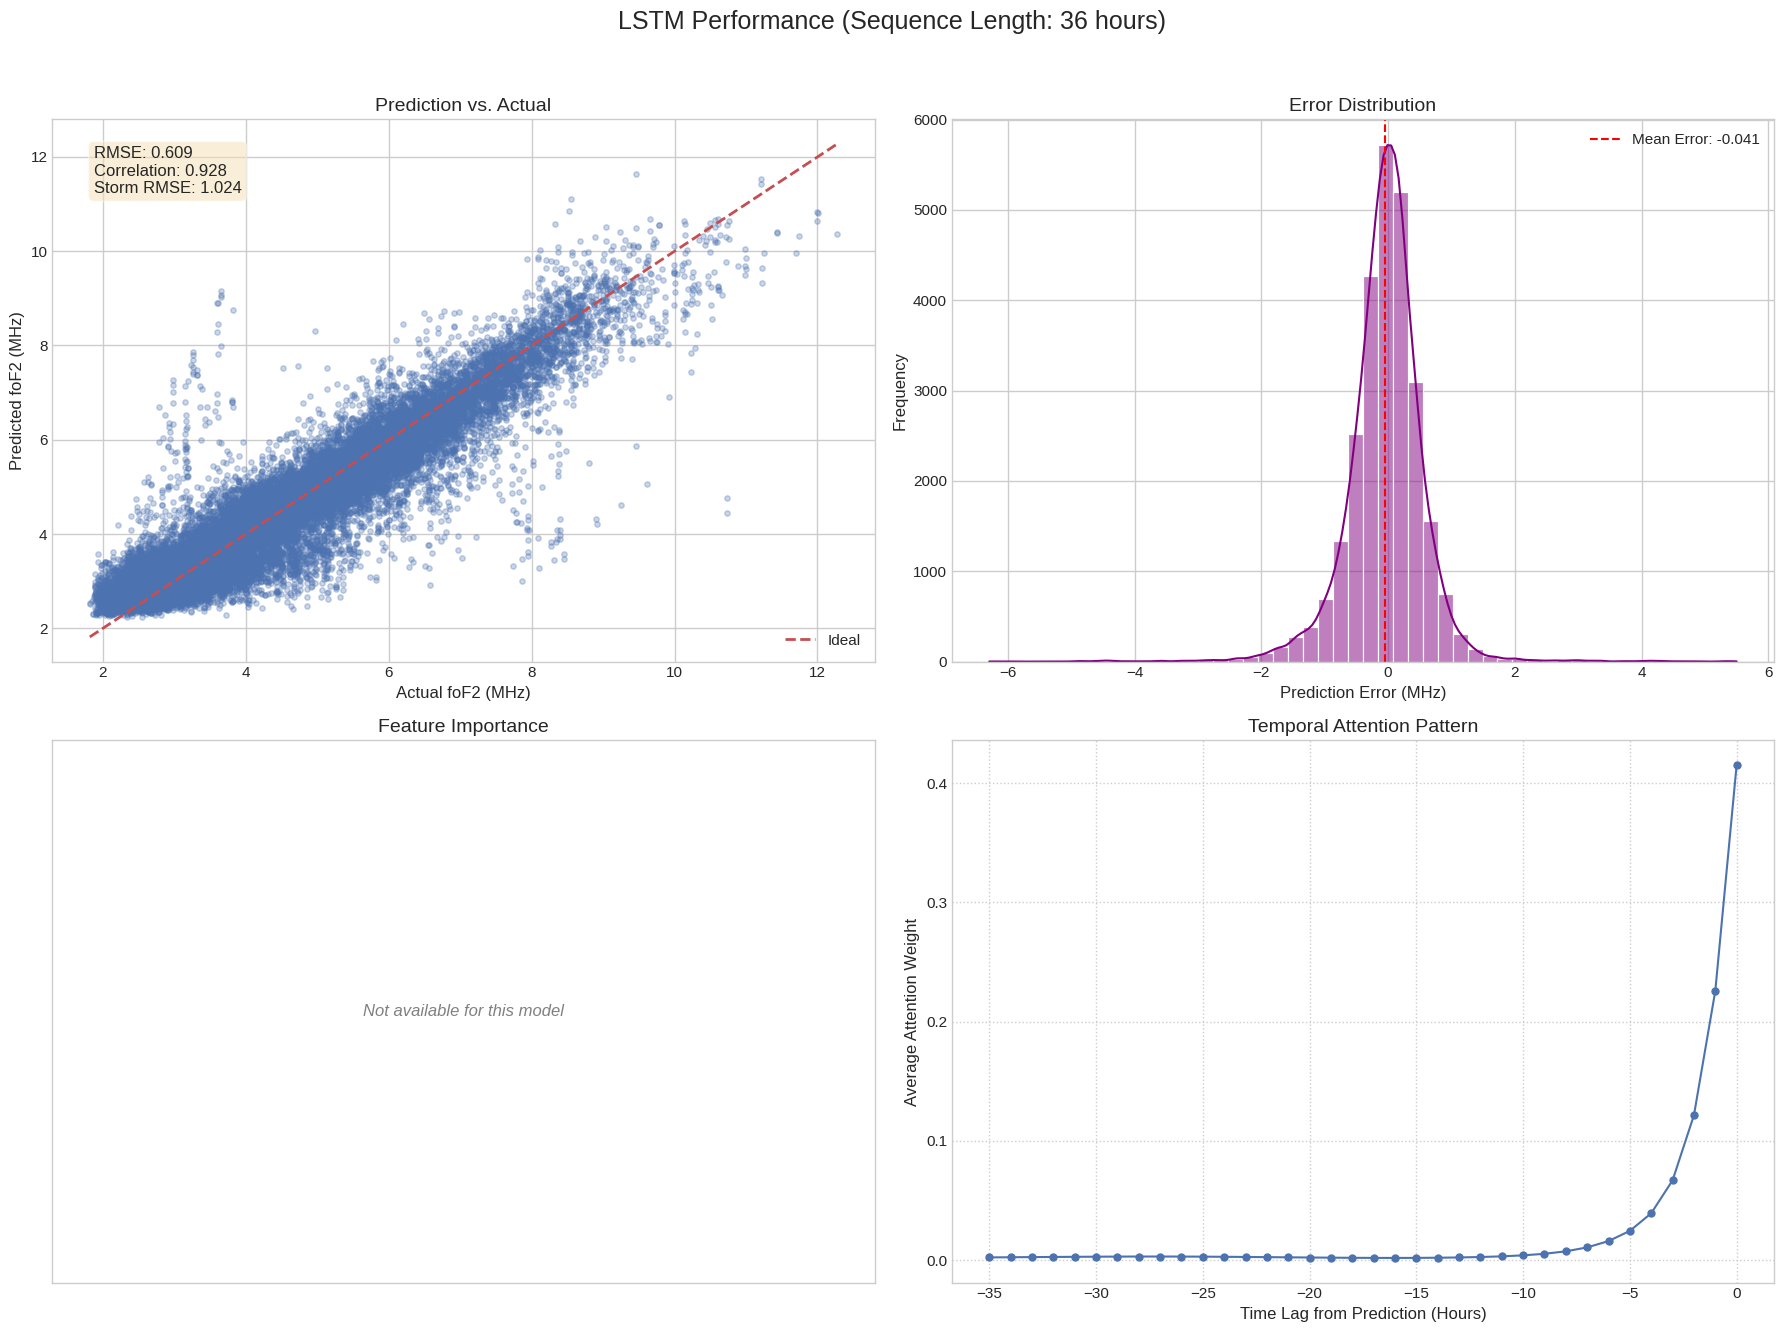


--- PROCESSING LSTM_48 (Sequence Length: 48 hours) ---
--- Loading detailed results for LSTM_48 for visualization. ---

Results plot saved to: /home/ioda/ionizeDL/results/lstm_len48_performance.png


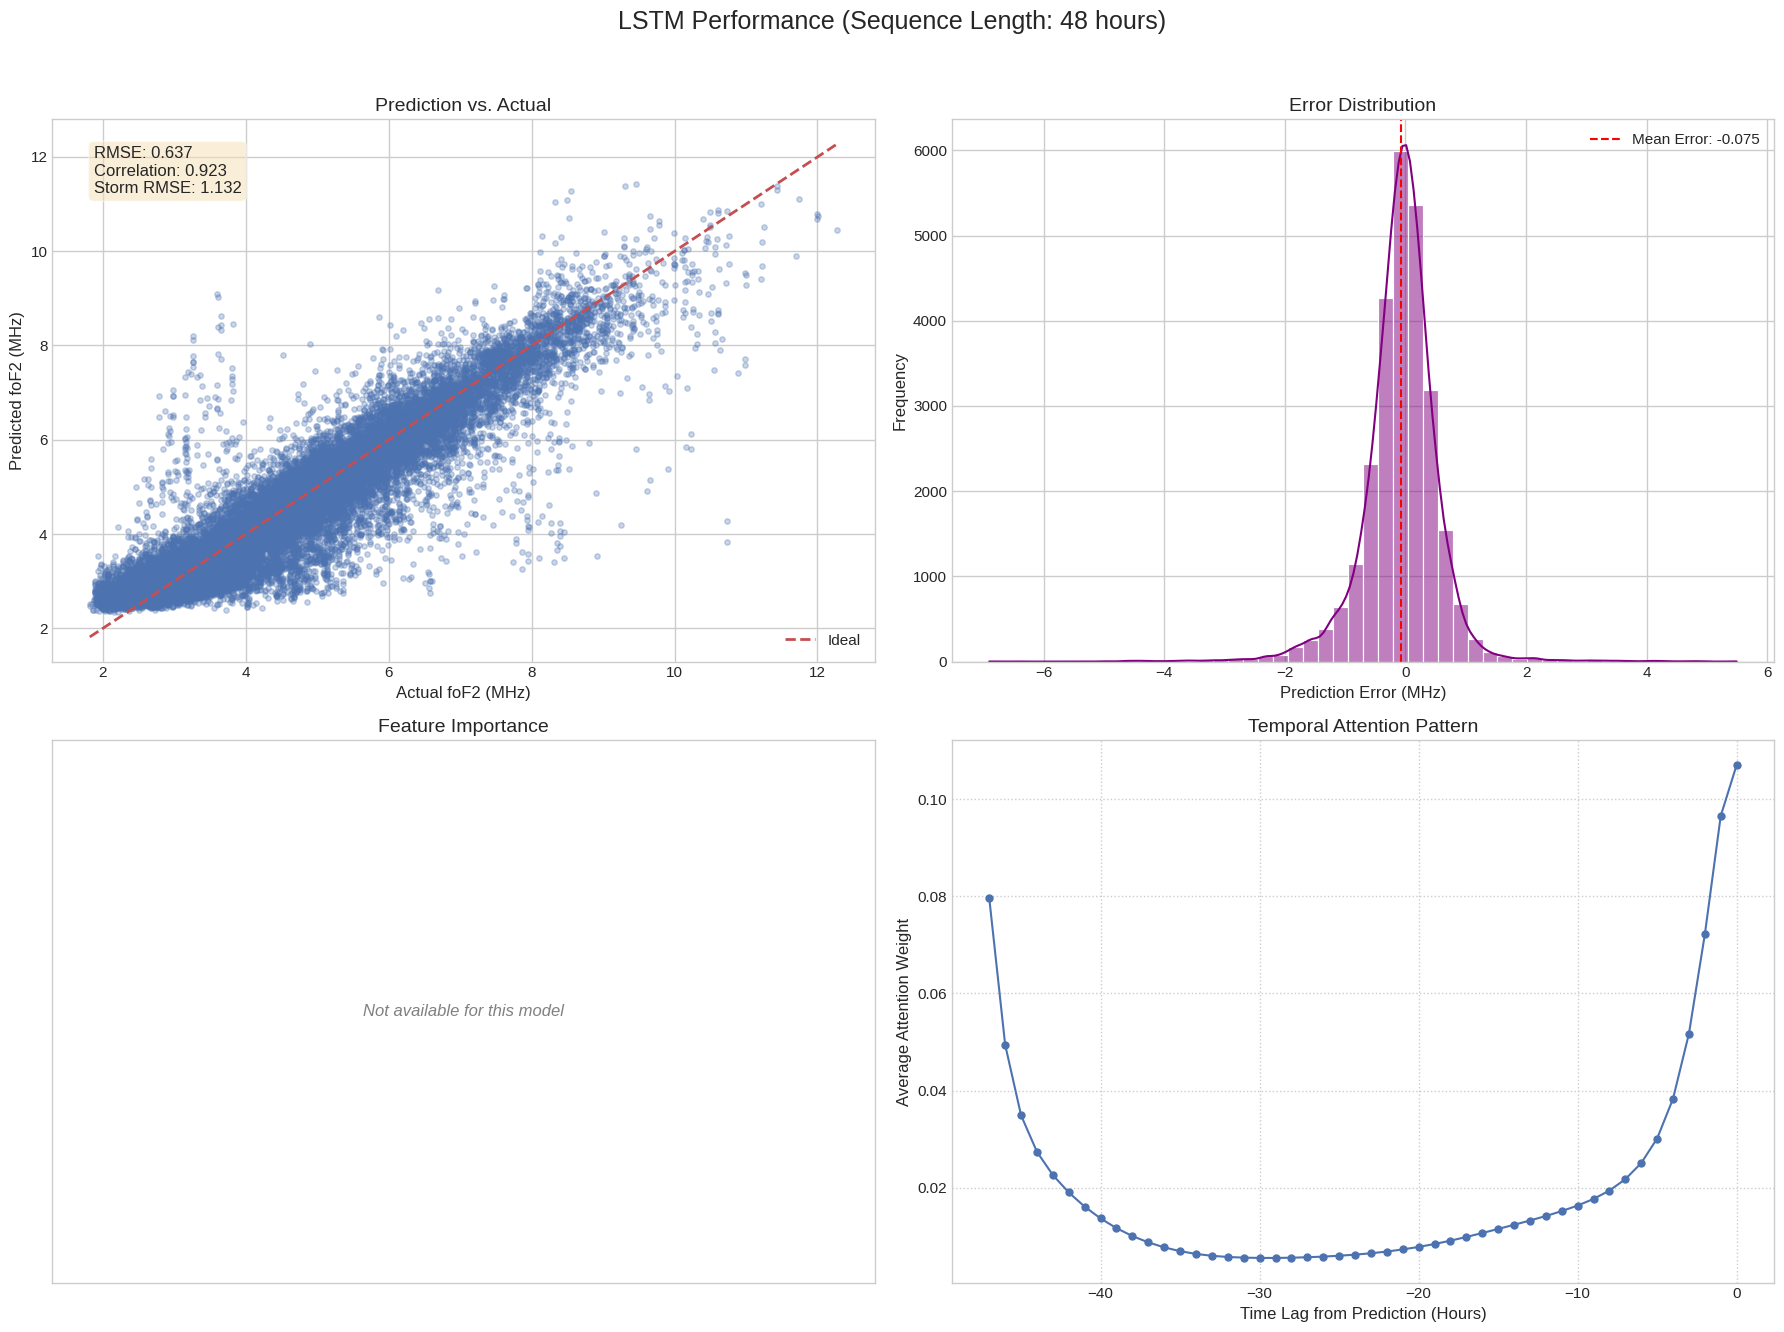


--- PROCESSING LSTM_60 (Sequence Length: 60 hours) ---
--- Loading detailed results for LSTM_60 for visualization. ---

Results plot saved to: /home/ioda/ionizeDL/results/lstm_len60_performance.png


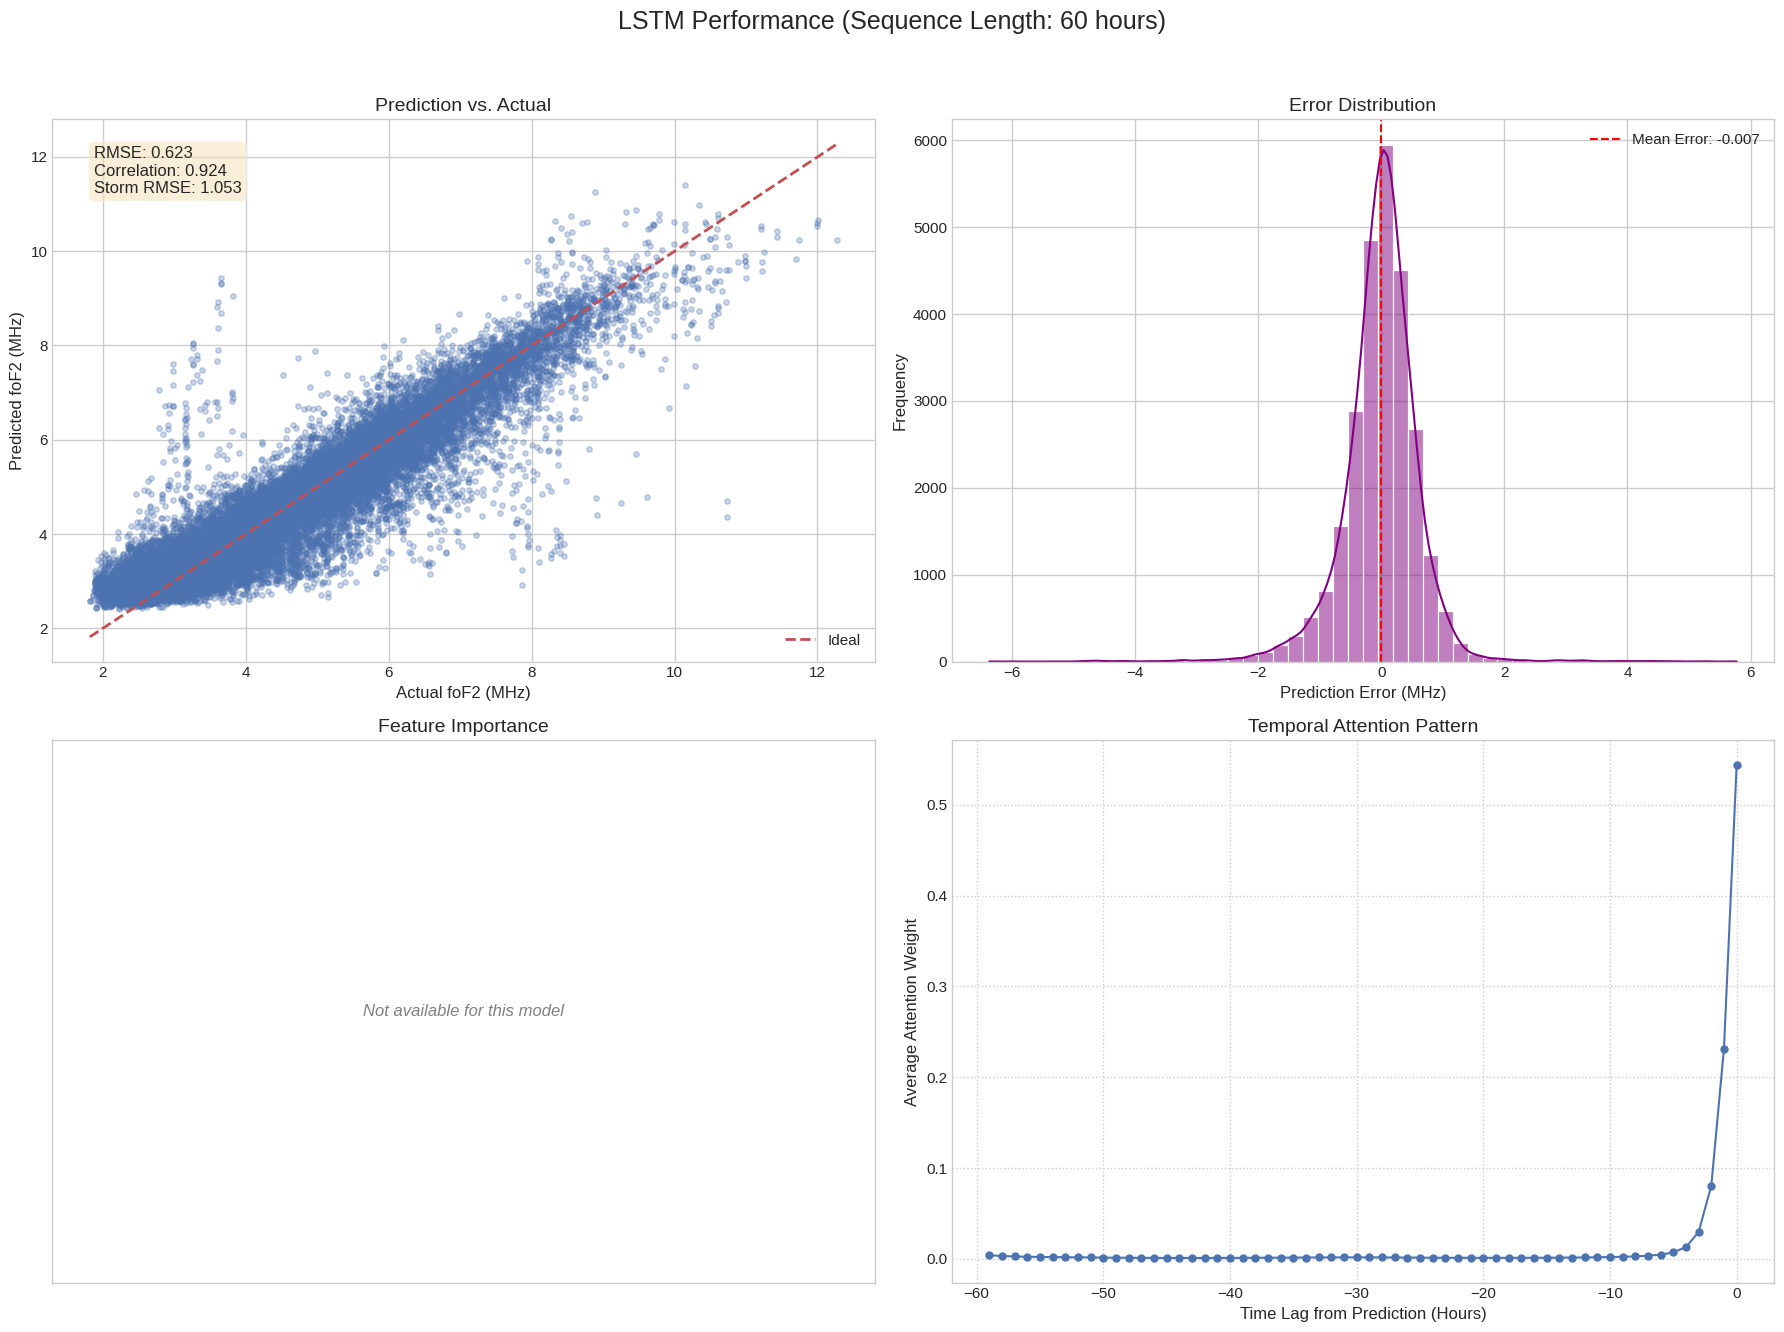


--- PROCESSING TFT_12 (Sequence Length: 12 hours) ---
--- Loading detailed results for TFT_12 for visualization. ---

Results plot saved to: /home/ioda/ionizeDL/results/tft_len12_performance.png


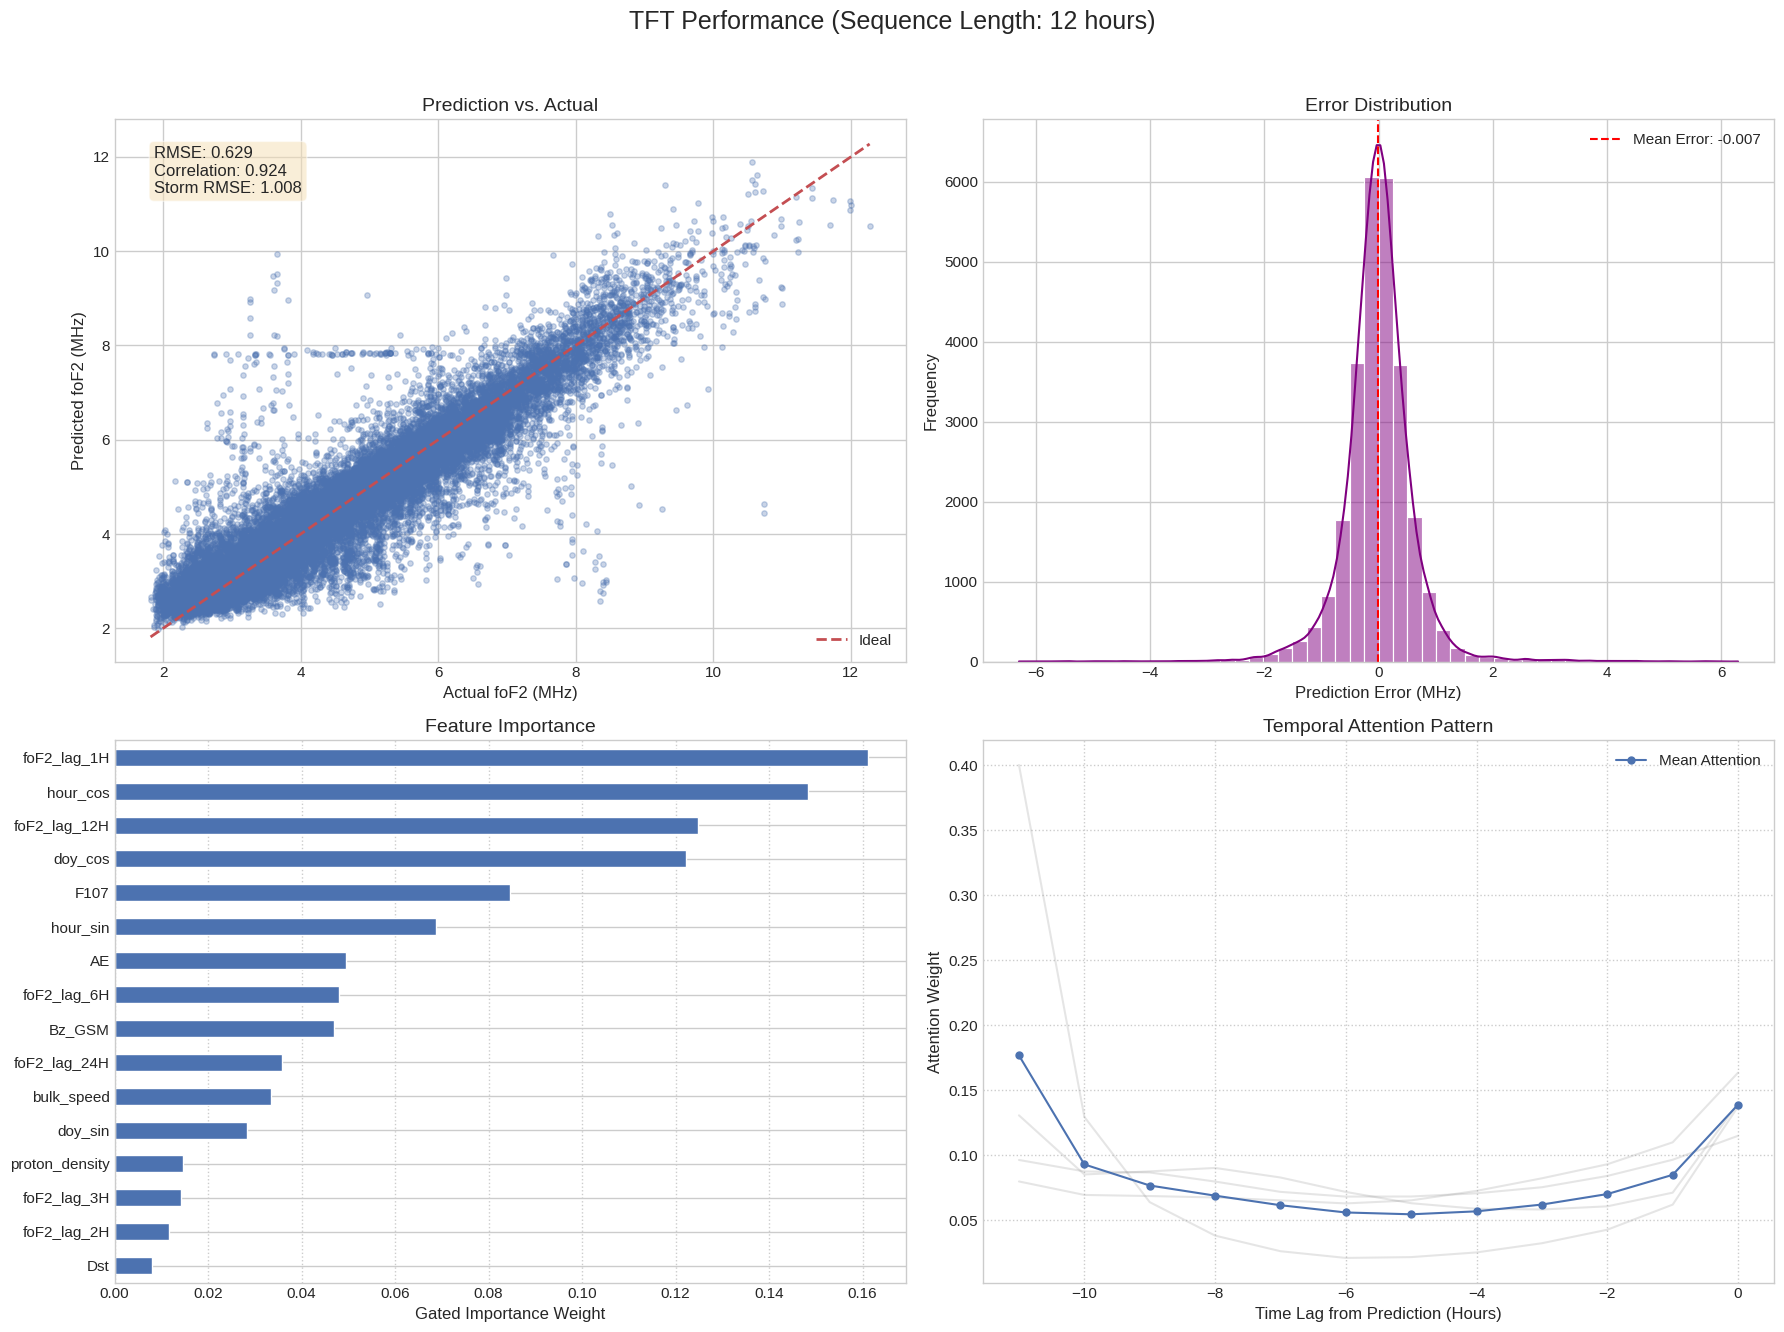


--- PROCESSING TFT_24 (Sequence Length: 24 hours) ---
--- Loading detailed results for TFT_24 for visualization. ---

Results plot saved to: /home/ioda/ionizeDL/results/tft_len24_performance.png


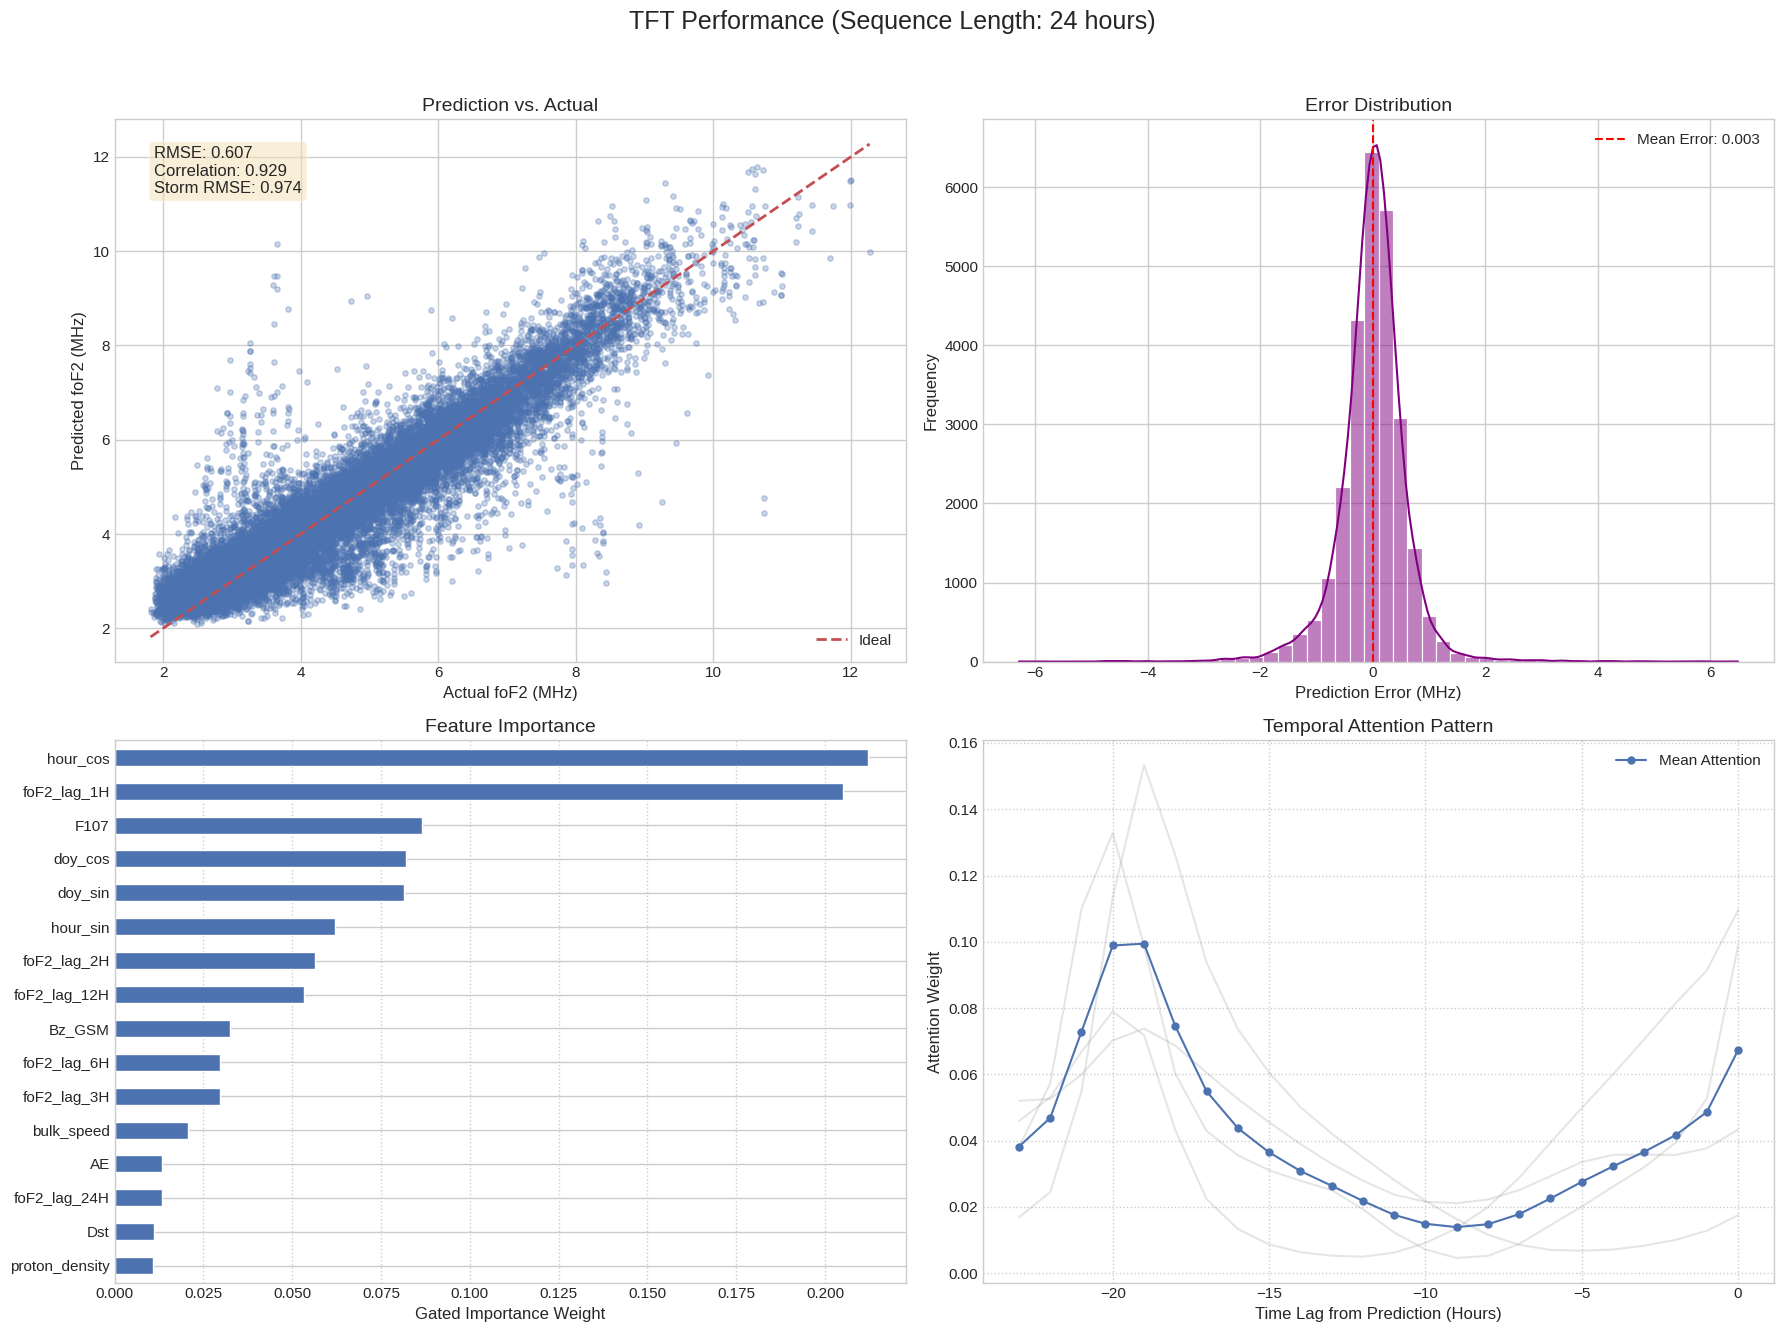



--- FINAL EXECUTION SUMMARY ---
model_type  sequence_length     rmse  correlation  storm_rmse  training_time_sec
      LSTM               12 0.627192     0.924645    1.033361         830.165755
      LSTM               24 0.618752     0.926221    1.020588         921.402357
      LSTM               36 0.609067     0.928187    1.023796        1166.236381
      LSTM               48 0.636801     0.922680    1.131631        1188.572551
      LSTM               60 0.623258     0.924128    1.052655        1363.375368
       TFT               12 0.628636     0.923540    1.008316        5594.929612
       TFT               24 0.606729     0.928818    0.974071        6721.538086


--- GENERATING COMPARATIVE VISUALIZATIONS ---

Loss curves plot saved to: /home/ioda/ionizeDL/results/LSTM_TFT_COMPARISON_loss_curves.png


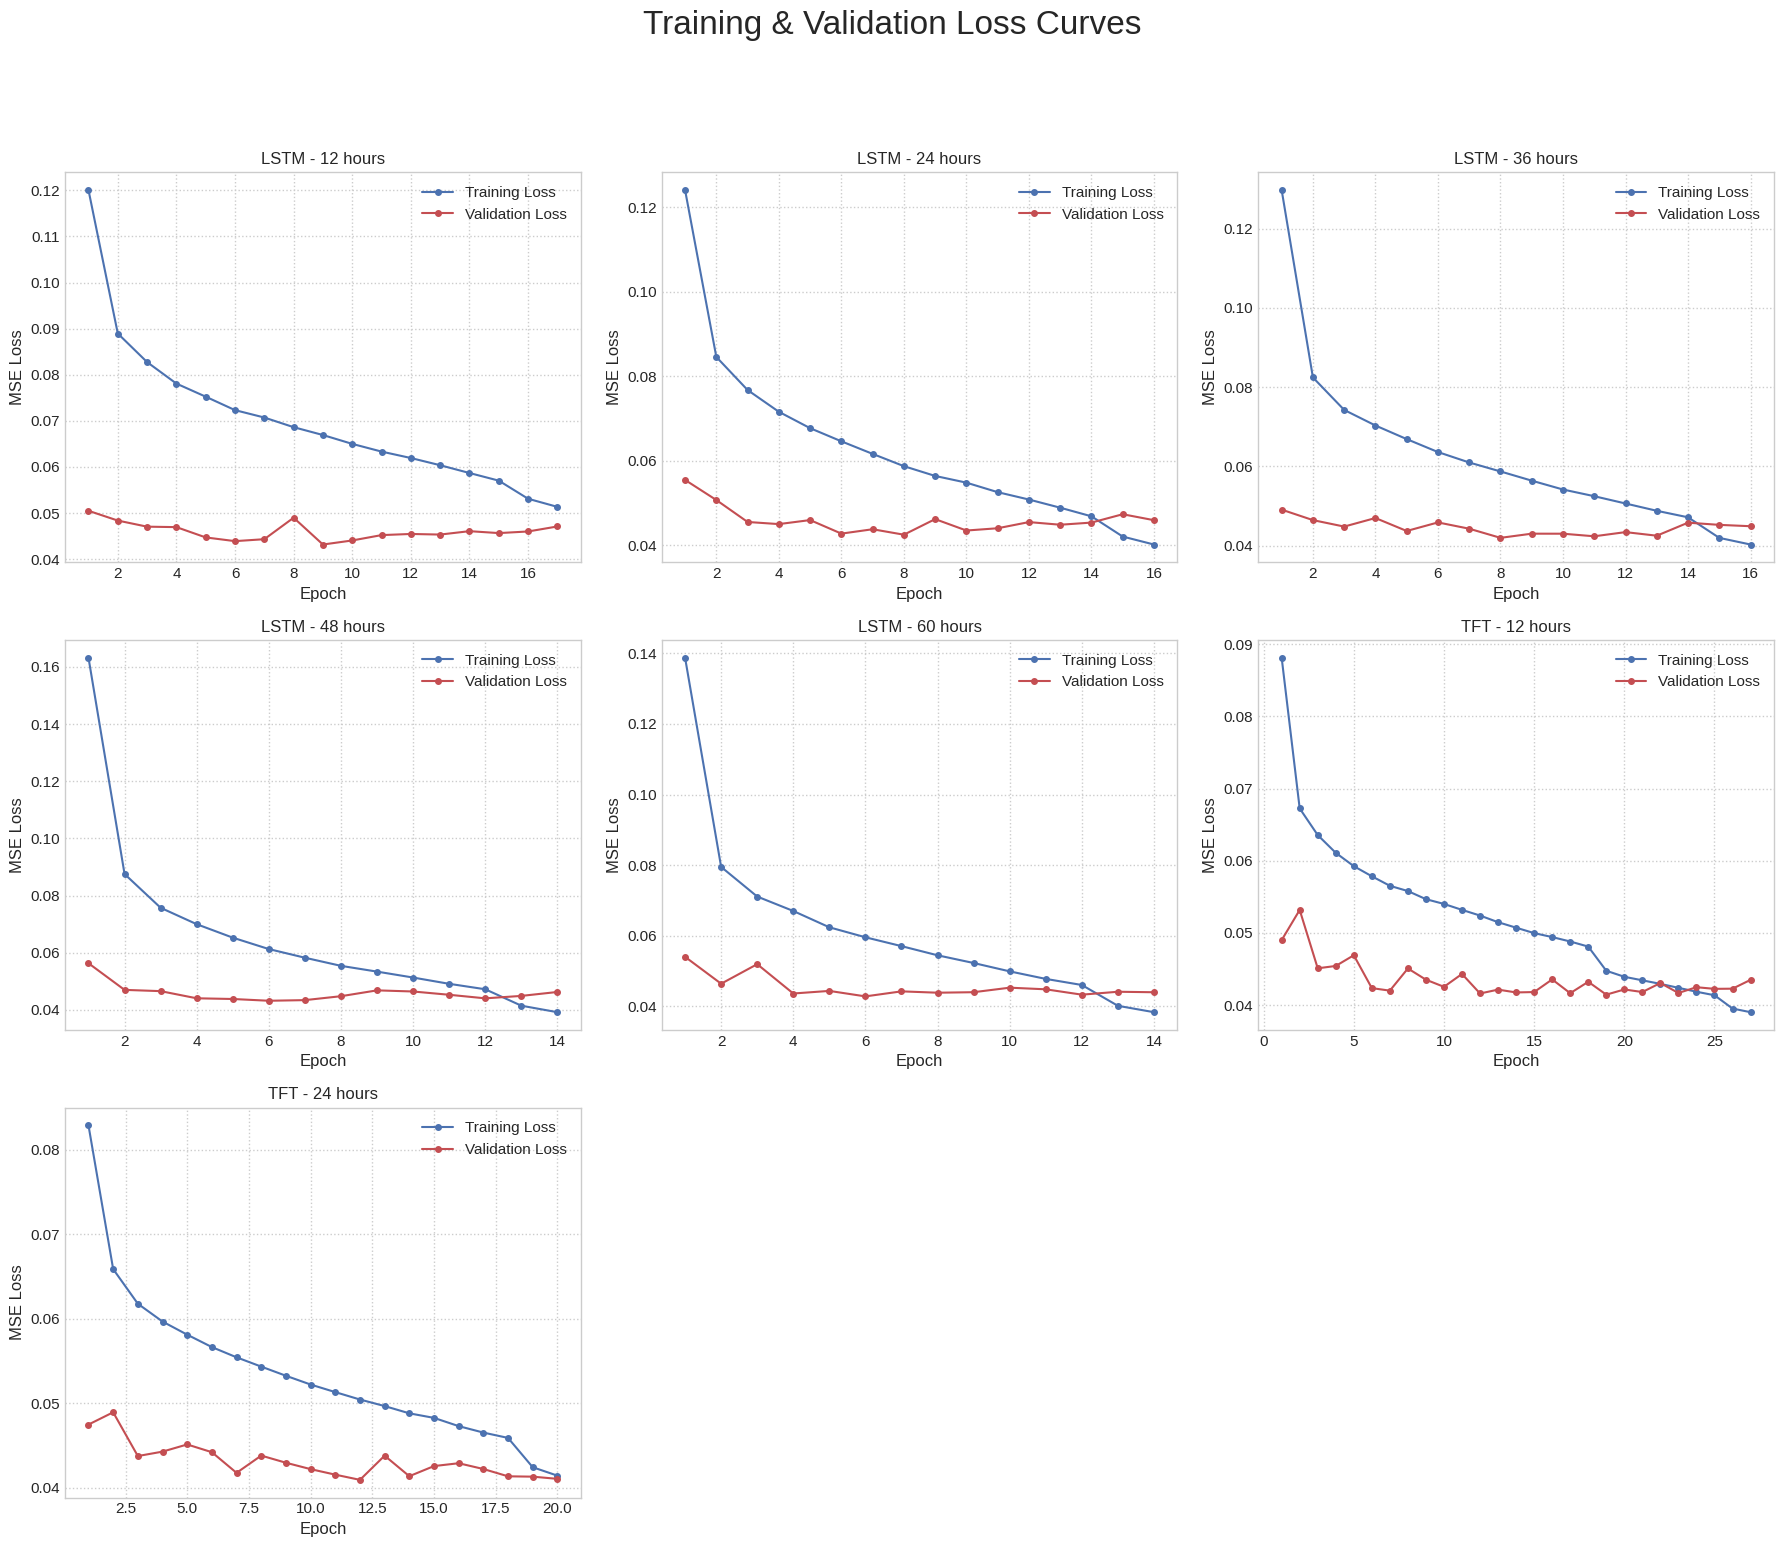


Comparative attention plot saved to: /home/ioda/ionizeDL/results/comparative_attention_patterns.png


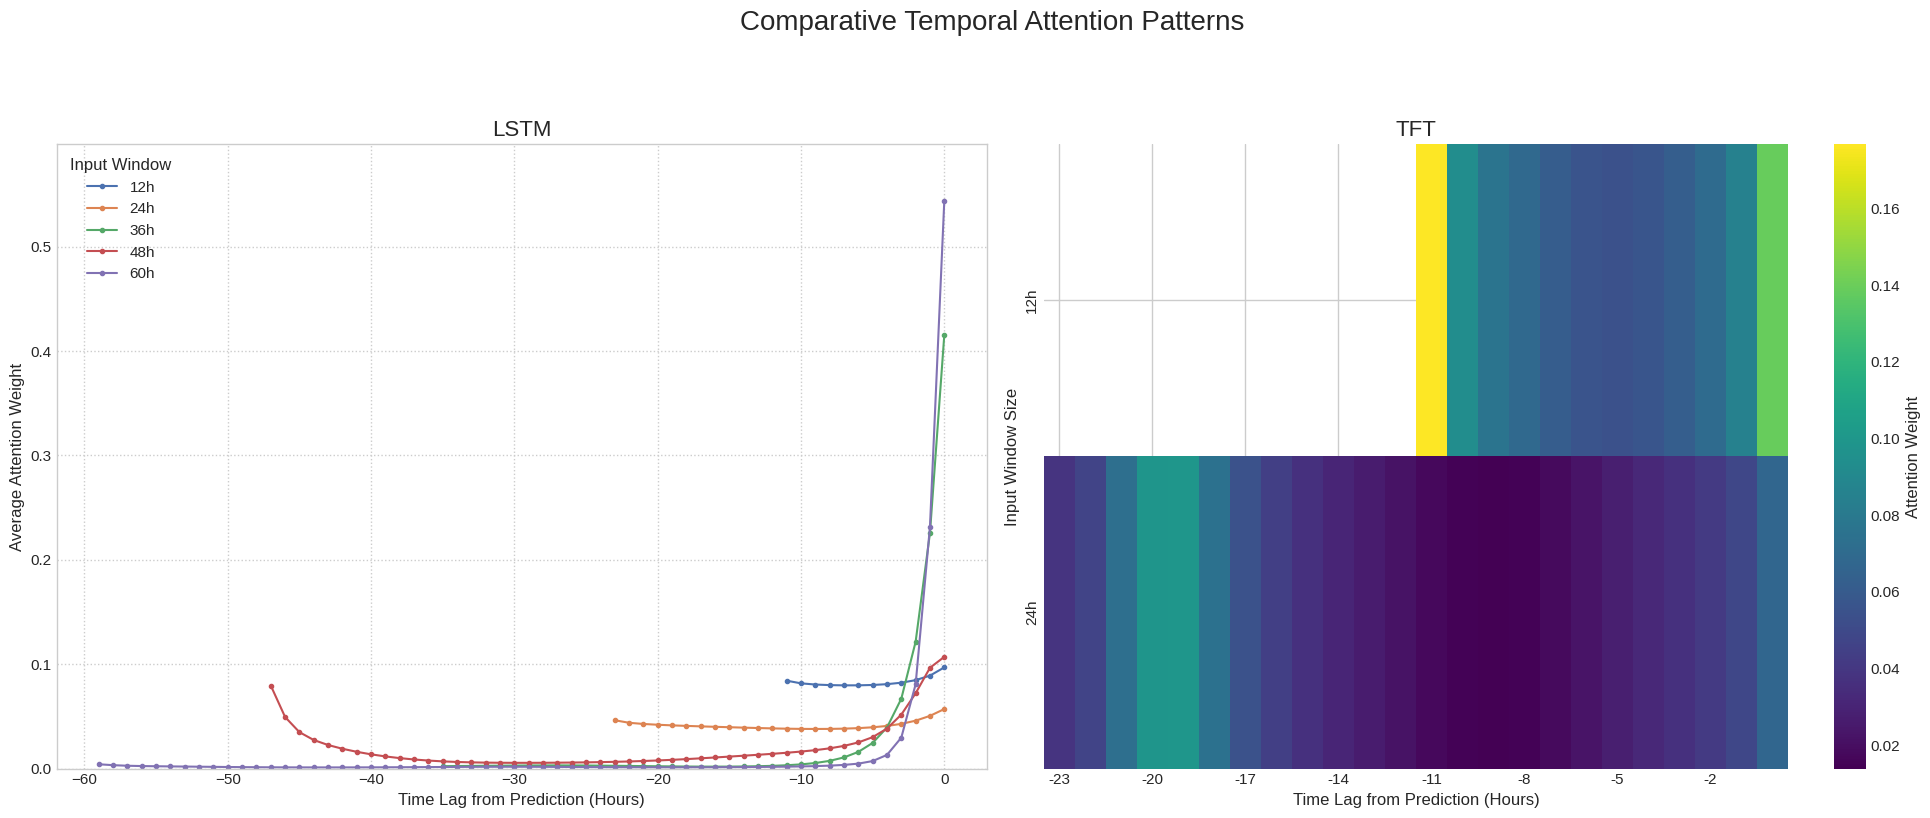

In [24]:
# =============================================================================
# SECTION 8: MAIN EXECUTION for LSTM/TFT
# =============================================================================

if __name__ == '__main__':
    if MODE == 'LSTM_TFT_COMPARISON':

        # --- Smart Logging and Data Collection Setup ---
        log_file_path = RESULTS_DIR / "results_log.csv"
        all_results_data = {}  # Dictionary to store detailed results for final plotting

        if log_file_path.exists():
            print(f"--- Found existing results log at: {log_file_path} ---")
            results_log_df = pd.read_csv(log_file_path)
            results_log = results_log_df.to_dict('records')
        else:
            print("--- No existing results log found. Starting fresh experiment. ---")
            results_log = []
            results_log_df = pd.DataFrame()

        print("\n--- Starting Comparison Experiment: LSTM vs. TFT ---")

        # Prepare the 'master' dataset once
        model_ready_df = get_processed_data()
        target_col = FOF2_CONFIG['char_name']
        feature_cols = [col for col in model_ready_df.columns if col not in [target_col, 'timestamp']]
        MODEL_PARAMS['input_features'] = len(feature_cols)

        lstm_tft_sequence_lengths = LSTM_TFT_SEQUENCE_LENGTHS if isinstance(LSTM_TFT_SEQUENCE_LENGTHS, list) else [LSTM_TFT_SEQUENCE_LENGTHS] # Ensure list format, in case a bare (single) value was entered

        # --- Main Loop ---
        for model_type in ['LSTM', 'TFT']:
            sequence_lengths = lstm_tft_sequence_lengths if model_type == 'LSTM' else [12, 24] # Assumes lengths 12 & 24 only, for TFT, as a default setting (for computational cost reasons). Please modify as desired!

            for seq_len in sequence_lengths:
                try:
                    run_id = f"{model_type}_{seq_len}"
                    model_savename = MODELS_DIR / f"ionizeDL_{model_type.lower()}_len{seq_len}.pth"
                    plot_savename = RESULTS_DIR / f"{model_type.lower()}_len{seq_len}_performance.png"
                    results_savename = RESULTS_DIR / f"{run_id}_details.pkl"

                    # Logic to handle existing runs or re-plotting
                    if results_savename.exists() and plot_savename.exists():
                        print(f"\n{'='*70}\n--- SKIPPING {run_id}: Full results already exist. ---\n{'='*70}")
                        with open(results_savename, 'rb') as f:
                            all_results_data[run_id] = pickle.load(f)
                        continue

                    print(f"\n{'='*70}\n--- PROCESSING {run_id} (Sequence Length: {seq_len} hours) ---\n{'='*70}")
                    
                    current_model_params = {**MODEL_PARAMS, 'sequence_length': seq_len}
                    
                    # Train, evaluate, and save results ONLY if the model checkpoint doesn't exist
                    if not model_savename.exists():
                        print(f"--- Training model: {model_savename.name} ---")
                        train_loader, val_loader, test_loader, _, target_scaler = create_dataloaders(
                            model_ready_df, feature_cols, target_col, current_model_params, TRAINING_PARAMS
                        )
                        if model_type == 'LSTM':
                            model = IonosphericPredictorLSTM(**{k: v for k, v in current_model_params.items() if k in ['input_features', 'hidden_dim', 'num_layers', 'dropout']}).to(device)
                        else: # TFT
                            model = TemporalFusionTransformer(input_size=current_model_params['input_features'], use_flash_attention=False).to(device)

                        training_time, train_loss, val_loss = train_model(model, train_loader, val_loader, current_model_params, TRAINING_PARAMS, model_savename)
                        
                        checkpoint = torch.load(model_savename)
                        model.load_state_dict(checkpoint['state_dict'])
                        results = evaluate_model(model, test_loader, target_scaler, device)
                        results['train_loss_history'] = train_loss
                        results['val_loss_history'] = val_loss
                        
                        with open(results_savename, 'wb') as f:
                            pickle.dump(results, f)
                        
                        run_exists_in_log = not results_log_df.empty and not results_log_df[(results_log_df['model_type'] == model_type) & (results_log_df['sequence_length'] == seq_len)].empty
                        if not run_exists_in_log:
                            results_log.append({'model_type': model_type, 'sequence_length': seq_len, 'rmse': results['rmse'], 'correlation': results['correlation'], 'storm_rmse': results['storm_rmse'], 'training_time_sec': training_time})
                            results_log_df = pd.DataFrame(results_log)
                            results_log_df.to_csv(log_file_path, index=False)
                            print(f"--- Results for {run_id} logged: RMSE={results['rmse']:.4f}, Corr={results['correlation']:.4f} ---")

                    # Load results into memory for plotting
                    if results_savename.exists():
                        print(f"--- Loading detailed results for {run_id} for visualization. ---")
                        with open(results_savename, 'rb') as f:
                            all_results_data[run_id] = pickle.load(f)
                    else:
                        print(f"--- ERROR: Cannot find results file for {run_id}. ---")
                        continue

                    # Generate individual visuals
                    plot_results(all_results_data[run_id], feature_cols, model_type, seq_len)

                except (KeyboardInterrupt, Exception) as e:
                    print(f"\n{'!'*70}")
                    print(f"--- RUN INTERRUPTED: An error occurred while processing {run_id}. ---")
                    print(f"--- Error: {e} ---")
                    print(f"--- Skipping to the next model. No results will be saved for this run. ---")
                    print(f"{'!'*70}\n")
                    # If the user interrupts, we want to stop completely.
                    if isinstance(e, KeyboardInterrupt):
                        print("--- Keyboard interrupt detected. Halting all experiments. ---")
                        break # Breaks the inner loop (seq_len)
                    continue # Continues to the next seq_len on other exceptions
                
                # This will break the outer loop (model_type) if a KeyboardInterrupt occurred
                else: # Corresponds to the inner for-loop
                    continue
                break


        # --- Final Summary and Comparative Visualization ---
        print(f"\n\n{'='*70}\n--- FINAL EXECUTION SUMMARY ---\n{'='*70}")
        if os.path.exists(log_file_path):
            final_summary_df = pd.read_csv(log_file_path).sort_values(by=['model_type', 'sequence_length'])
            print(final_summary_df.to_string(index=False)) 
            
            # Comparative visualization
            print(f"\n\n{'='*70}\n--- GENERATING COMPARATIVE VISUALIZATIONS ---\n{'='*70}")
            plot_loss_curves(final_summary_df, all_results_data, MODE) 
            plot_comparative_attention(final_summary_df, all_results_data)
        
        else:
            print("--- No results log found. Cannot generate summary or visualizations. ---")

    else:
        print(f"Mode '{MODE}' is not supported for this block. Please set MODE to 'LSTM_TFT_COMPARISON'.")

In [ ]:
# =============================================================================
# APPENDIX: Going "beyond" transformers
# An experiment with a basic Mamba STATE-SPACE MODEL (SSM)
# Older version --- NOT tested with latest code
# =============================================================================

class MambaBlock(nn.Module):
    """
    A numerically stable Mamba block.

    Handles "NaN" errors by implementing a robust parallel scan,
    essential for stable training.

    Reference: Gu, A., & Dao, T. (2023). Mamba: Linear-Time Sequence Modeling
                 with Selective State Spaces. arXiv.
    """
    def __init__(self, d_model, d_state=16, d_conv=4):
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state
        self.d_conv = d_conv

        # Projections and convolution layers
        self.in_proj = nn.Linear(d_model, 2 * d_model, bias=False)
        self.conv1d = nn.Conv1d(
            in_channels=d_model, out_channels=d_model,
            kernel_size=d_conv, padding=d_conv - 1,
            groups=d_model, bias=True
        )
        self.x_proj = nn.Linear(d_model, d_state + d_state, bias=False)
        self.dt_proj = nn.Linear(d_model, d_model, bias=True)

        # State-space parameter 'A' initialization
        A = torch.arange(1, d_state + 1, dtype=torch.float32).repeat(d_model, 1)
        self.A_log = nn.Parameter(torch.log(A))

        # Final output projection and normalization
        self.out_norm = nn.LayerNorm(d_model)
        self.out_proj = nn.Linear(d_model, d_model, bias=True)

    def forward(self, x):
        B, L, D = x.shape
        x_res = x # Store residual for later

        xz = self.in_proj(x)
        x_in, z = xz.chunk(2, dim=-1)

        x_conv = self.conv1d(x_in.transpose(1, 2))[:, :, :L].transpose(1, 2)
        
        # Capture gate value for visualization
        self.gate = F.silu(x_conv) * z
        
        y = self.selective_scan(self.gate)
        
        # Add residual connection and normalize
        y = self.out_norm(y + x_res)
        
        return self.out_proj(y)

    def selective_scan(self, x):
        B, L, D = x.shape
        N = self.d_state

        A = -torch.exp(self.A_log.float())
        delta = F.softplus(self.dt_proj(x))
        
        x_proj_out = self.x_proj(x)
        B_param, C_param = x_proj_out.chunk(2, dim=-1)

        delta_A = torch.exp(torch.einsum('bld,dn->bldn', delta, A))
        delta_B_x = torch.einsum('bld,bln,bld->bldn', delta, B_param, x)

        # STABLE Parallel Scan
        # Uses a cumulative product
        ys = []
        h = torch.zeros(B, D, N, device=x.device)
        for i in range(L):
            h = delta_A[:, i] * h + delta_B_x[:, i]
            ys.append(h)
        h_scanned = torch.stack(ys, dim=1)

        y = torch.einsum('bldn,bln->bld', h_scanned, C_param)
        return y

class SsmForecaster(nn.Module):
    """A forecasting model built upon a stack of Mamba blocks."""
    def __init__(self, input_features, d_model=64, n_layers=4, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_features, d_model)
        self.layers = nn.ModuleList([MambaBlock(d_model) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x)
        
        # Capture gate values from each layer
        gate_magnitudes = []
        for layer in self.layers:
            x = layer(x) + x # Residual connection for stability
            gate_magnitudes.append(torch.mean(layer.gate, dim=-1)) # Store the gate magnitude from each layer


        # Average gate magnitudes across all layers for stable visualization
        self.avg_gate_magnitude = torch.mean(torch.stack(gate_magnitudes), dim=0)

        x = self.norm(x[:, -1, :])
        output = self.output_layer(x)
        
        # Return captured gate magnitude (instead of a dummy tensor)
        return output, self.avg_gate_magnitude

print("Numerically stable SSM (Mamba) model defined successfully.")

In [ ]:
# =============================================================================
# APPENDIX main execution: SSM & final comparison
# Older version --- NOT tested with latest code
# =============================================================================

if __name__ == '__main__':
    if MODE == 'SSM_EXPERIMENT':
        # --- Smart Logging Setup ---
        log_file_path = RESULTS_DIR / "results_log.csv"
        if not log_file_path.exists():
            print(f"Error: Results log not found at {log_file_path}")
            print("For *comparative* results, please run the initial LSTM/TFT experiment first.")
        else:
            print(f"--- Found existing results log: {log_file_path} ---")
            # Load the most recent log into a dataframe
            results_log_df = pd.read_csv(log_file_path)
            # Maintain the full log as a list of dictionaries for easy appending
            results_log = results_log_df.to_dict('records')
            all_results_data = {} # Initialize dict to hold data for plotting

            print("\n--- Starting Stage 2 Experiment: SSM ---")
            
            model_ready_df = get_processed_data()
            target_col = FOF2_CONFIG['char_name']
            feature_cols = [col for col in model_ready_df.columns if col not in [target_col, 'timestamp']]
            MODEL_PARAMS['input_features'] = len(feature_cols)

            ssm_sequence_lengths = SSM_SEQUENCE_LENGTHS if isinstance(SSM_SEQUENCE_LENGTHS, list) else [SSM_SEQUENCE_LENGTHS]

            for seq_len in ssm_sequence_lengths:
                run_id = f"SSM_{seq_len}"
                model_savename = MODELS_DIR / f"ionizeDL_ssm_len{seq_len}.pth"
                results_savename = RESULTS_DIR / f"{run_id}_results.pkl"
                
                # Train only if model file does not exist
                if not model_savename.exists():
                    print(f"\n{'='*70}\n--- TRAINING {run_id} ---\n{'='*70}")
                    current_model_params = {**MODEL_PARAMS, 'sequence_length': seq_len}
                    train_loader, val_loader, test_loader, _ = create_dataloaders(
                        model_ready_df, feature_cols, target_col, current_model_params, TRAINING_PARAMS
                    )
                    model = SsmForecaster(input_features=current_model_params['input_features']).to(device)
                    training_time, train_loss, val_loss = train_model(model, train_loader, val_loader, current_model_params, TRAINING_PARAMS, model_savename)

                    # Evaluate right after training
                    model.load_state_dict(torch.load(model_savename))
                    results = evaluate_model(model, test_loader, scaler, device)
                    
                    # Store history and save detailed results
                    results['train_loss_history'] = train_loss
                    results['val_loss_history'] = val_loss
                    with open(results_savename, 'wb') as f:
                        pickle.dump(results, f)
                    
                    # Update log in memory
                    results_log = [r for r in results_log if not (r['model_type'] == 'SSM' and r['sequence_length'] == seq_len)]
                    results_log.append({ 'model_type': 'SSM', 'sequence_length': seq_len, 'rmse': results['rmse'], 'correlation': results['correlation'], 'storm_rmse': results['storm_rmse'], 'training_time_sec': training_time })

                # Load results into memory for plotting
                if results_savename.exists():
                    print(f"--- Loading results for {run_id} for visualization. ---")
                    with open(results_savename, 'rb') as f:
                        all_results_data[run_id] = pickle.load(f)
                else:
                    print(f"--- WARNING: No results file for {run_id}. Evaluating from .pth file. ---")
                    # Fallback if .pkl is missing but .pth exists
                    if model_savename.exists():
                        # ... (code to create dataloaders and model) ...
                        model.load_state_dict(torch.load(model_savename))
                        all_results_data[run_id] = evaluate_model(model, test_loader, scaler, device)
                    else:
                        print(f"--- ERROR: Cannot find any files for {run_id} to generate visuals. ---")
                        continue
                
                # Generate visuals
                print("\n--- Generating Visualizations for this Run ---")
                plot_ssm_diagnostics(all_results_data[run_id], 'SSM', seq_len)
            
            # --- Final, robust save of the entire log ---
            print(f"\n\n{'='*70}\n--- FINALIZING LOG FILE ---")
            final_df = pd.DataFrame(results_log).sort_values(by=['model_type', 'sequence_length'])
            final_df.to_csv(log_file_path, index=False)
            print("Results log updated successfully.")

            # --- Generate Combined Loss Curve Plot ---
            print("\n--- Generating Final Combined Loss Curve Plot ---")
            if all_results_data:
                 plot_all_loss_curves(final_df, all_results_data)

            # --- Print Final Summary Table ---
            print(f"\n{'='*70}\n--- FINAL COMBINED EXPERIMENT SUMMARY ---\n{'='*70}")
            print(final_df.to_string(index=False))
            
    else:
        print(f"Mode '{MODE}' is not supported. Set MODE to 'SSM_EXPERIMENT'.")